# 0.0. Imports

In [1]:
import os
import pandas                                                           as pd
import inflection
import math
import numpy                                                            as np
import seaborn                                                          as sns
import matplotlib.pyplot                                                as plt
import datetime
import xgboost                                                          as xgb
import random
import pickle
import json
import requests

from tabulate                   import tabulate
from scipy                      import stats                            as ss
#from boruta                    import BorutaPy
from flask                      import Flask, request, Response

from sklearn.ensemble           import RandomForestRegressor
from sklearn.linear_model       import LinearRegression, Lasso
from sklearn.metrics            import mean_absolute_error, mean_squared_error
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, LabelEncoder


from IPython.core.display       import HTML
from IPython.display            import Image

import warnings
warnings.filterwarnings('ignore')

## 0.2. Helper Functions

In [2]:
rs = RobustScaler()
mms = MinMaxScaler()
le = LabelEncoder()


def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 13]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

def cramer_v(x , y):
    cm = pd.crosstab (x , y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency (cm) [0]
    chi2corr = max( 0, chi2 - (k - 1) * (r - 1) / (n -1) )

    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    return np.sqrt ( (chi2corr / n) / (min (kcorr - 1, rcorr - 1) ) )


def mean_percentage_error (y, yhat):
    return np.mean ((y - yhat) / y)

def mean_absolute_percentage_error (y, yhat):
    return np.mean (np.abs ((y - yhat) / y))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error (y,yhat)
    mape = mean_absolute_percentage_error (y,yhat)
    rsme = np.sqrt (mean_squared_error (y,yhat))

    return pd.DataFrame ( { 'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rsme }, index = [0] )


def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []


    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )

    # start and end date for validation
    validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    # training and validation dataset
    # training
    xtraining = training.drop( ['date', 'sales'], axis=1 )
    ytraining = training['sales']

    # validation
    xvalidation = validation.drop( ['date', 'sales'], axis=1 )
    yvalidation = validation['sales']

    # model
    m = model.fit( xtraining, ytraining )

    # prediction
    yhat = m.predict( xvalidation )

    # performance
    m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )

    # store performance of each kfold iteration
    mae_list.append( m_result['MAE'] )
    mape_list.append( m_result['MAPE'] )
    rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

Populating the interactive namespace from numpy and matplotlib


## 0.3. Loading Data

In [3]:
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '../data/store.csv', low_memory=False )

# merge

df_raw = pd.merge (df_sales_raw, df_store_raw, how = 'left', on='Store')

# 1.0. Data Description

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns


In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list (map (snakecase, cols_old) )

# rename
df1.columns = cols_new

In [6]:
df1 = df1.rename(columns={'promo' :'promo_week',
                        'promo2' : 'promo_month',
                        'promo2_since_week' : 'promo_month_since_week',
                        'promo2_since_year' : 'promo_month_since_year'})

## 1.2. Data Dimensions

In [7]:
print ('Number os Rows: {}'.format (df1.shape[0]))
print ('Number os Columns: {}'.format (df1.shape[1]))

Number os Rows: 1017209
Number os Columns: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo_week                               int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo_month                              int64
promo_month_since_week                 float64
promo_month_since_year                 float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo_week                           0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo_month                          0
promo_month_since_week          508031
promo_month_since_year          508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply (lambda x : 200000.0 if math.isnan ( x ) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan (x ['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan (x ['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

# promo_month_since_week
df1['promo_month_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan (x ['promo_month_since_week']) else x['promo_month_since_week'], axis = 1)


# promo_month_since_year
df1['promo_month_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan (x ['promo_month_since_year']) else x['promo_month_since_year'], axis = 1)


# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna (0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map (month_map)
df1['promo_month_active'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )

In [11]:
df1.sample(5).T

,258942,279312,118218,928038,497088
store,151,1024,29,29,584
day_of_week,7,7,4,4,6
date,2014-12-07 00:00:00,2014-11-16 00:00:00,2015-04-16 00:00:00,2013-03-21 00:00:00,2014-04-12 00:00:00
sales,0,0,9215,6570,4440
customers,0,0,747,591,447
open,0,0,1,1,1
promo_week,0,0,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,c,d,d,d


In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo_week                      0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo_month                     0
promo_month_since_week          0
promo_month_since_year          0
promo_interval                  0
month_map                       0
promo_month_active              0
dtype: int64

## 1.6. Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo_week                               int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo_month                              int64
promo_month_since_week                 float64
promo_month_since_year                 float64
promo_interval                          object
month_map                               object
promo_month_active                       int64
dtype: object

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype (int)
df1['competition_open_since_year'] =df1['competition_open_since_year'].astype (int)

df1['promo_month_since_week'] = df1['promo_month_since_week'].astype (int)
df1['promo_month_since_year'] = df1['promo_month_since_year'].astype (int)

## 1.7. Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes (include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes (exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [16]:
# central tendency - mean, median
ct1 = pd.DataFrame (num_attributes.apply (np.mean)).T
ct2 = pd.DataFrame (num_attributes.apply (np.median)).T

#dispersion - std, min, max, skew, kurtosis
d1 = pd.DataFrame (num_attributes.apply (np.std)).T
d2 = pd.DataFrame (num_attributes.apply (min)).T
d3 = pd.DataFrame (num_attributes.apply (max)).T
d4 = pd.DataFrame (num_attributes.apply (lambda x : x.max() - x.min())).T
d5 = pd.DataFrame (num_attributes.apply (lambda x: x.skew())).T
d6 = pd.DataFrame (num_attributes.apply (lambda x: x.kurtosis())).T

#concatenate
r = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
r.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
r

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo_week,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


- A distribuição de vendas:

    - possui assimetria (visto que média e mediana apresentam valores distintos, mas sem diferenças exorbitantes);

    - de acordo com o valor do std, há uma dispersão de valores que podem variar em torno da média, o que é compreensível, visto que vendas são voláteis. Outliers também podem estar influenciado esse valor;

    - com skew de 0.64, a variável vendas possui uma assimetria positiva relativamente moderada, indicando que valores mais altos ocorrem com menos frequência do que valores mais baixos;
    
    - uma curtose de 1.77837 indica que é cauda é pontiaguda, havendo uma alta concentração de dados em valores "mais baixos".

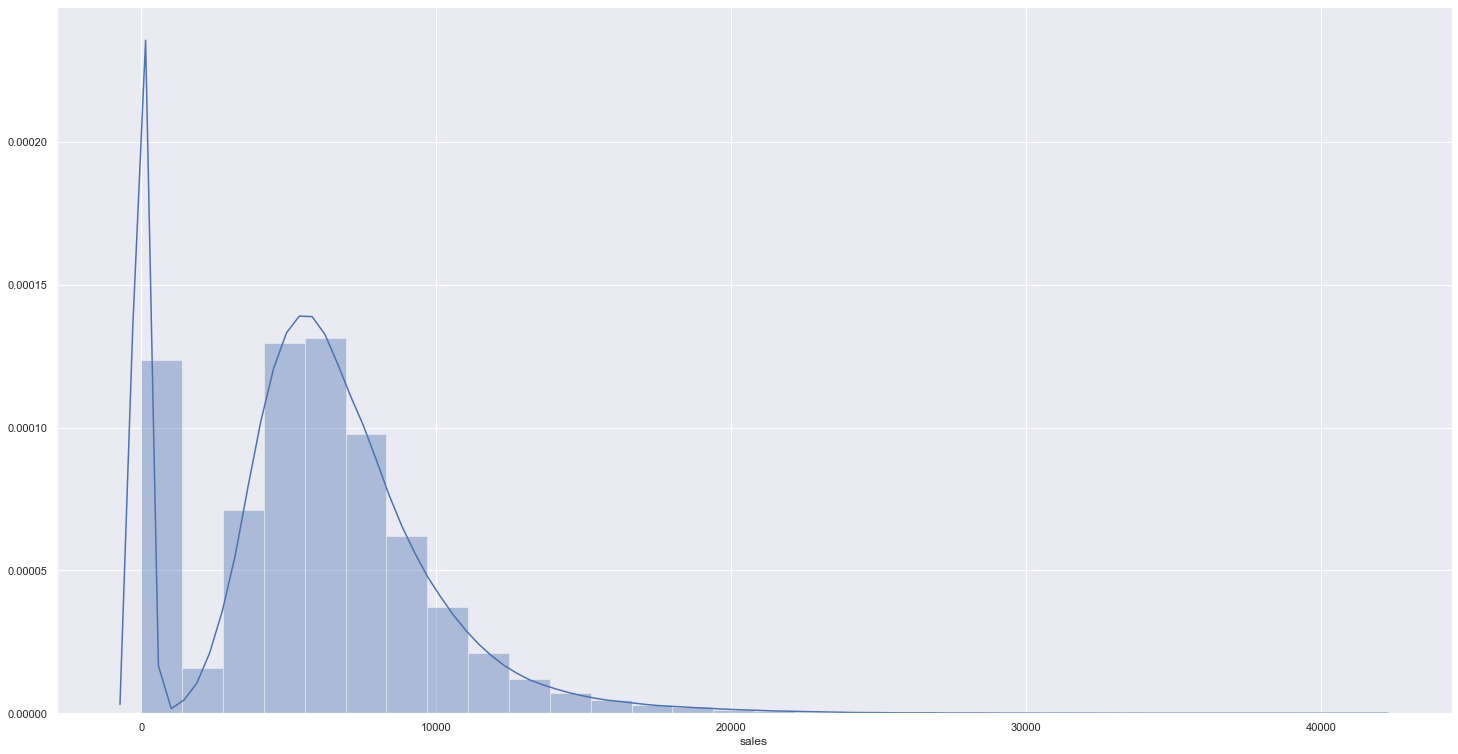

In [17]:
#variável vendas com valores 0
sns.distplot (df1['sales'], bins=30);

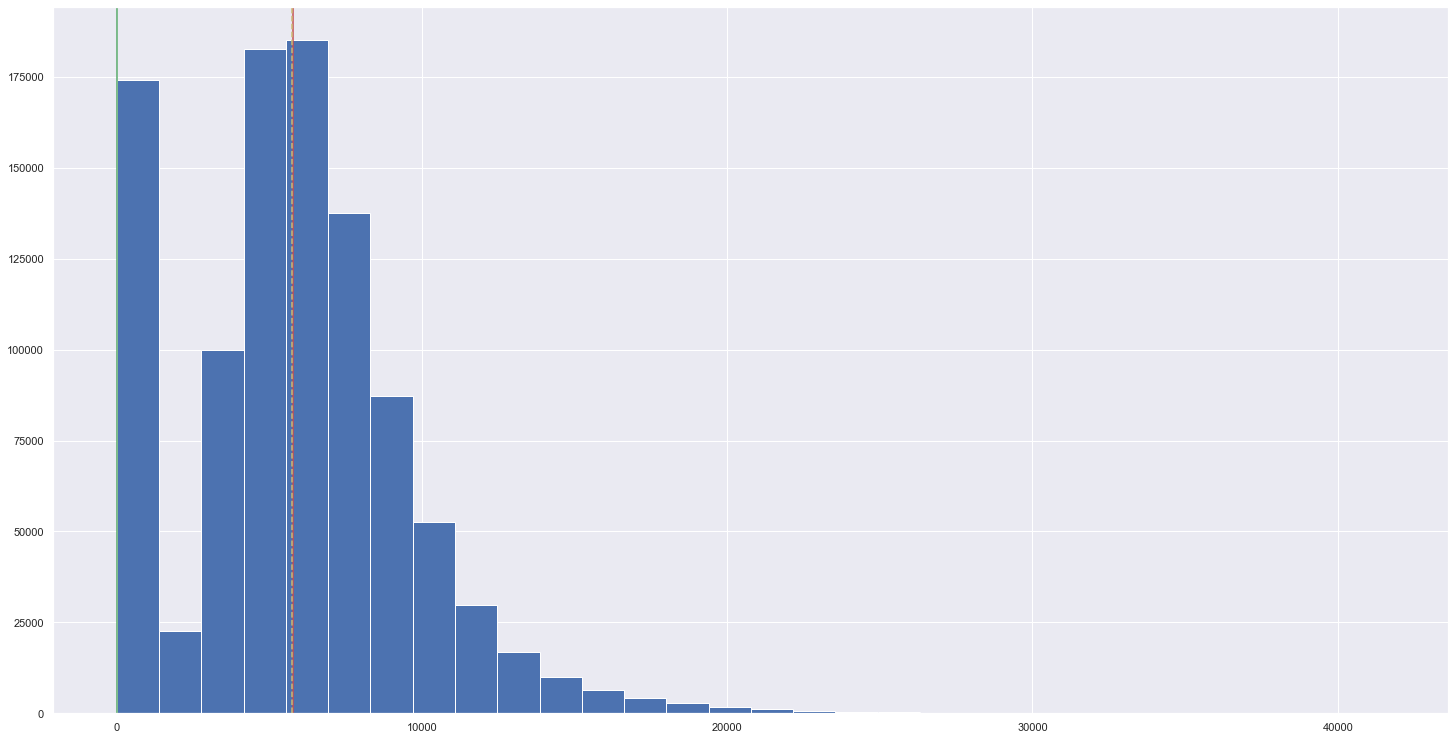

média: 5773.818972305593
mediana: 5744.0
moda: 0    0
dtype: int64
desvio padrão: 3849.92617523476


In [18]:
media = df1['sales'].mean()
mediana = df1['sales'].median()
moda = df1['sales'].mode()
desvio_padrao = df1['sales'].std()

plt.hist(df1['sales'], bins = 30);
plt.axvline(x=media, color='r', linestyle='-')
plt.axvline(x=mediana, color='y', linestyle='dashed')
plt.axvline(x=moda[0], color='g', linestyle='-')
plt.show()

print('média: '+ str(media))
print('mediana: '+ str(mediana))
print('moda: '+ str(moda))
print('desvio padrão: '+ str(desvio_padrao))

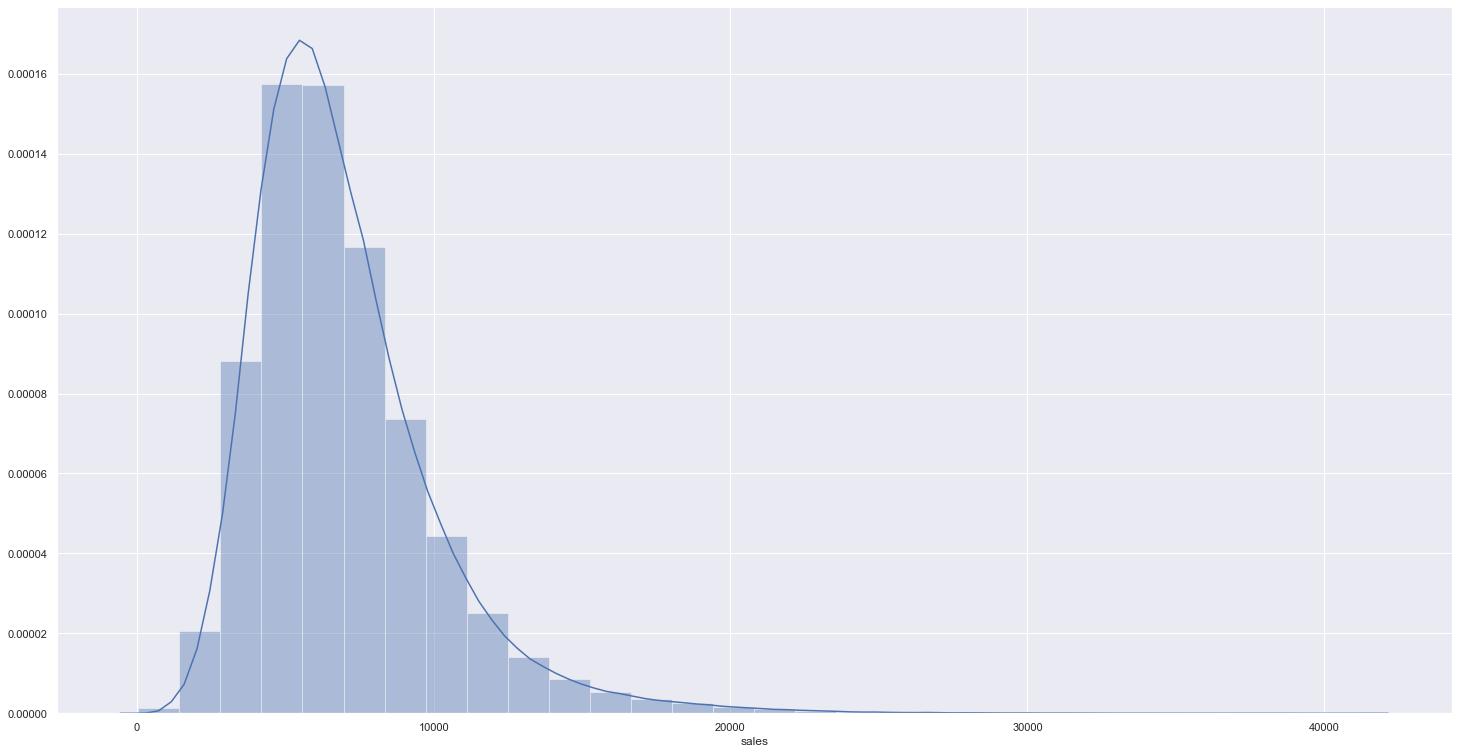

In [19]:
#variável venda sem os valores 0
sales_ = df1[df1['sales'] != 0 ]
sns.distplot(sales_['sales'], bins=30);

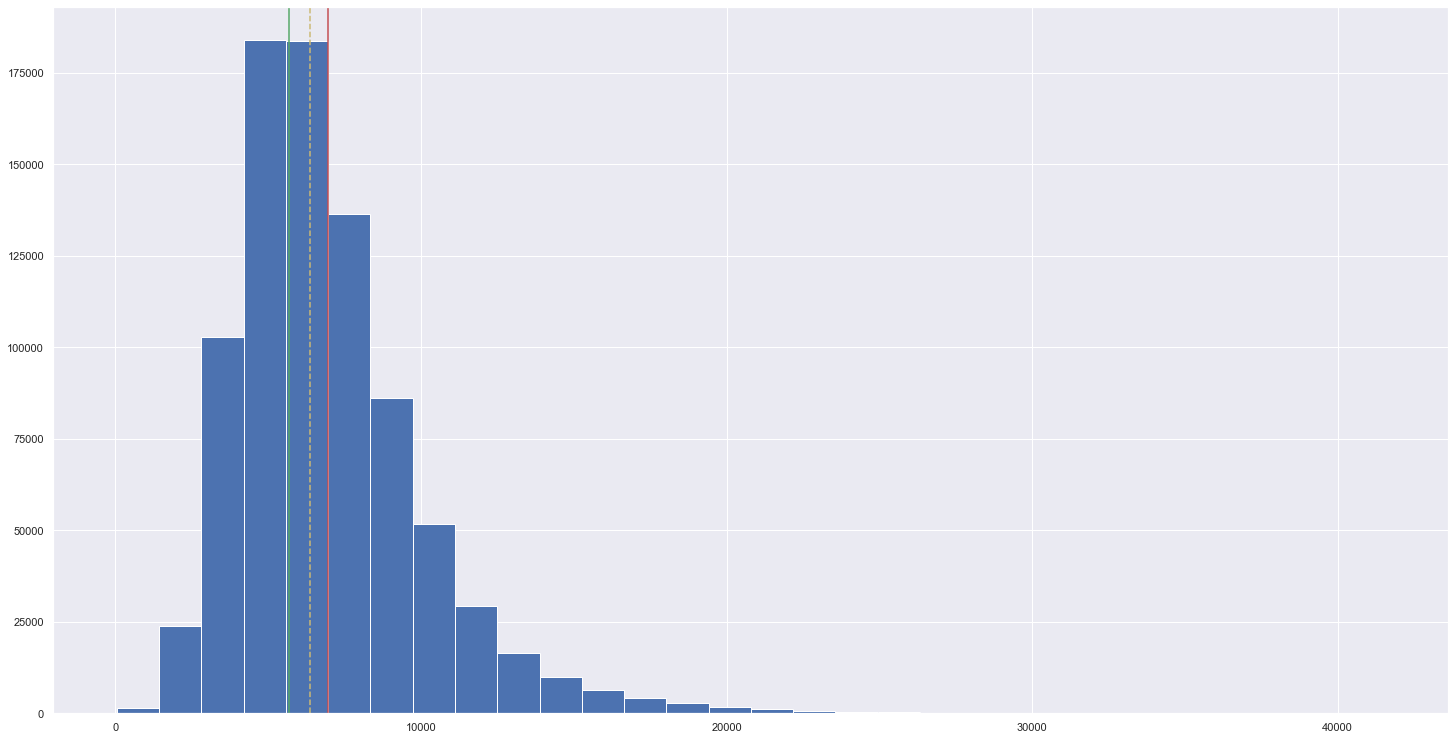

média: 6955.959133664481
mediana: 6369.0
moda: 0    5674
dtype: int64
desvio padrão: 3103.8155154905603


In [20]:
media = sales_['sales'].mean()
mediana = sales_['sales'].median()
moda = sales_['sales'].mode()
desvio_padrao = sales_['sales'].std()

plt.hist(sales_['sales'], bins = 30);
plt.axvline(x=media, color='r', linestyle='-')
plt.axvline(x=mediana, color='y', linestyle='dashed')
plt.axvline(x=moda[0], color='g', linestyle='-')
plt.show()

print('média: '+ str(media))
print('mediana: '+ str(mediana))
print('moda: '+ str(moda))
print('desvio padrão: '+ str(desvio_padrao))

### Categorical Attributes

In [21]:
cat_attributes.apply (lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

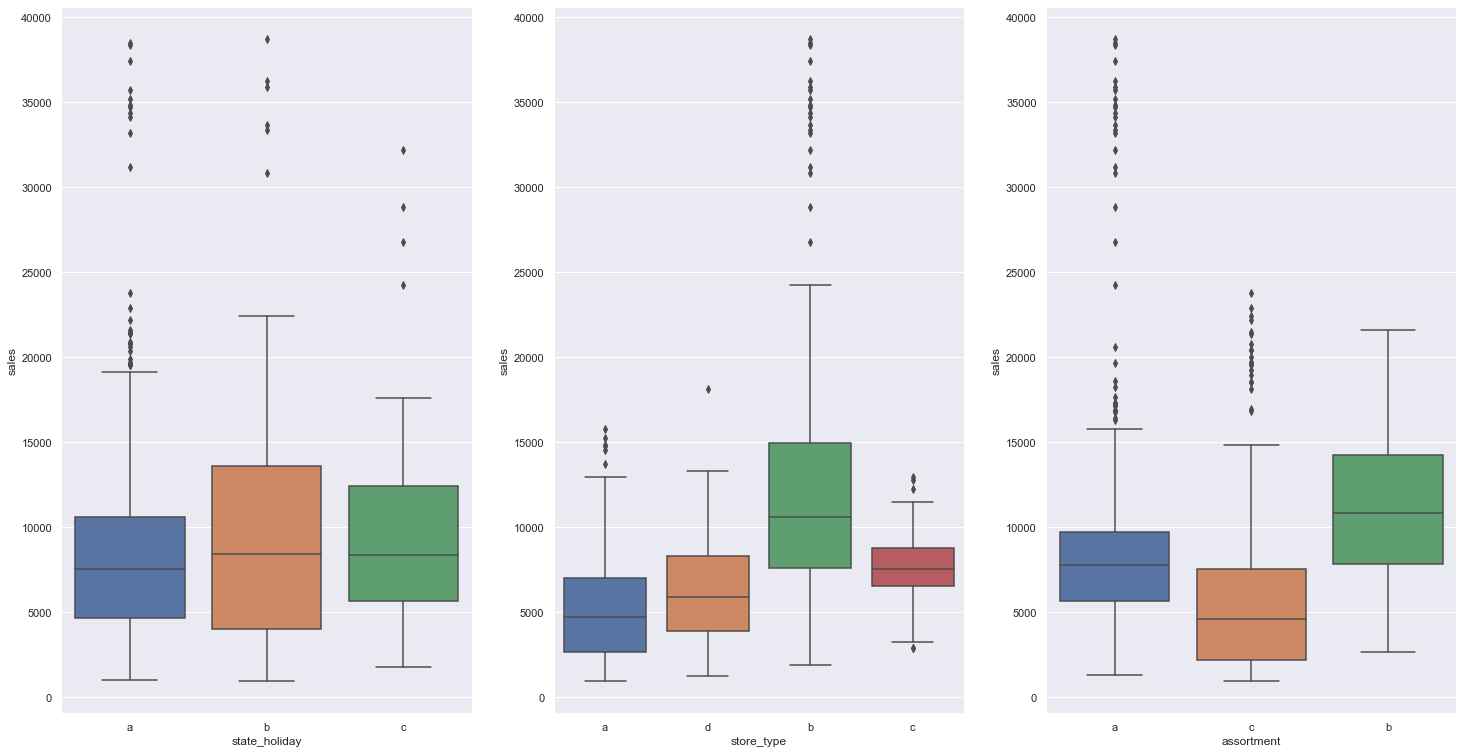

In [22]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot (1, 3, 1)
sns.boxplot (x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot (1, 3, 2)
sns.boxplot (x = 'store_type', y = 'sales', data = aux1);

plt.subplot (1, 3, 3)
sns.boxplot (x = 'assortment', y = 'sales', data = aux1);

In [23]:
# g1 = aux1.groupby('state_holiday')['sales'].describe()
# g2 = aux1.groupby('store_type')['sales'].describe()
# g3 = aux1.groupby('assortment')['sales'].describe()

# g3

Legendas:

- state_holiday:  

    - a = public holiday
    - b = Easter holiday
    - c = Christmas
    -   0 = None


- assortment:

    - a = basic
    - b = extra
    - c = extended


# 2.0. Feature Engineering

In [24]:
df2 = df1.copy()

## 2.1. Mental Map of Hypotheses

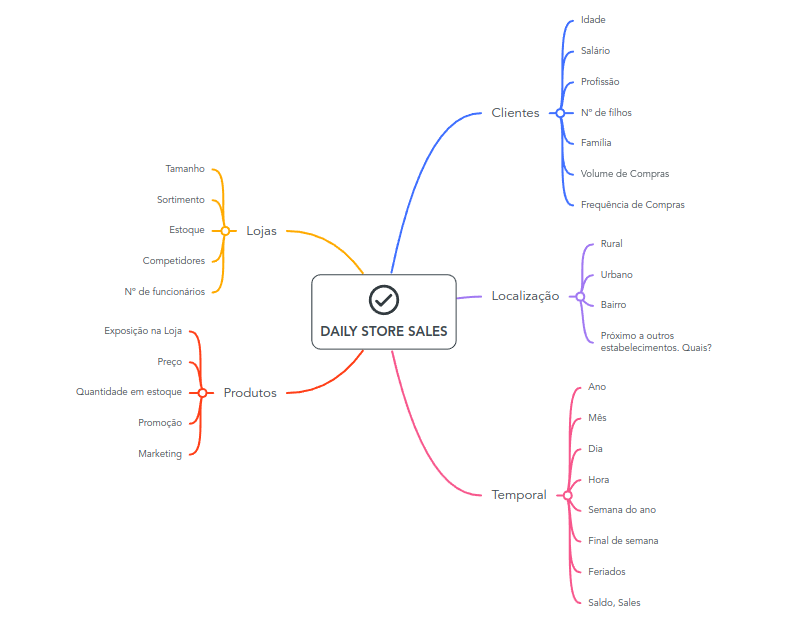

In [25]:
Image('../img/MindMapHypothesis.png')

## 2.2. Creation of Hypotheses

### 2.2.1. Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores há mais tempo deveriam vender mais.

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas que participam das duas promoções deveriam vender mais.

### 2.2.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais na primeira quinzena de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Final List of Hypotheses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas que participam das duas promoções deveriam vender mais.

**5.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**6.** Lojas deveriam vender mais ao longo dos anos.

**7.** Lojas deveriam vender mais na primeira quinzena de cada mês.

**8.** Lojas deveriam vender menos aos finais de semana.

**9.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Engineering

In [26]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime ('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day= 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo_month
df2['promo_month_since_date'] = df2['promo_month_since_year'].astype(str) + '-' + df2['promo_month_since_week'].astype(str)
df2['promo_month_since_date'] = df2['promo_month_since_date'].apply(lambda x: datetime.datetime.strptime (x + '-1', '%Y-%W-%w') - datetime.timedelta (days = 7))
df2['promo_month_time_week'] = ((df2['date'] - df2['promo_month_since_date']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply (lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply (lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [27]:
df2.sample(3).T

,95350,387191,940552
store,576,334,278
day_of_week,4,3,7
date,2015-05-07 00:00:00,2014-07-23 00:00:00,2013-03-10 00:00:00
sales,7019,3634,0
customers,928,411,0
open,1,1,0
promo_week,1,0,0
state_holiday,regular_day,regular_day,regular_day
school_holiday,0,1,0
store_type,c,d,a


# 3.0. Variable Filters

In [28]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [29]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [30]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop (cols_drop, axis = 1)

In [31]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo_week', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year',
       'promo_month', 'promo_month_since_week', 'promo_month_since_year',
       'promo_month_active', 'year', 'month', 'day', 'week_of_year',
       'year_week', 'competition_since', 'competition_time_month',
       'promo_month_since_date', 'promo_month_time_week'],
      dtype='object')

# 4.0. Exploratory Data Analysis

In [32]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1 Response Variable

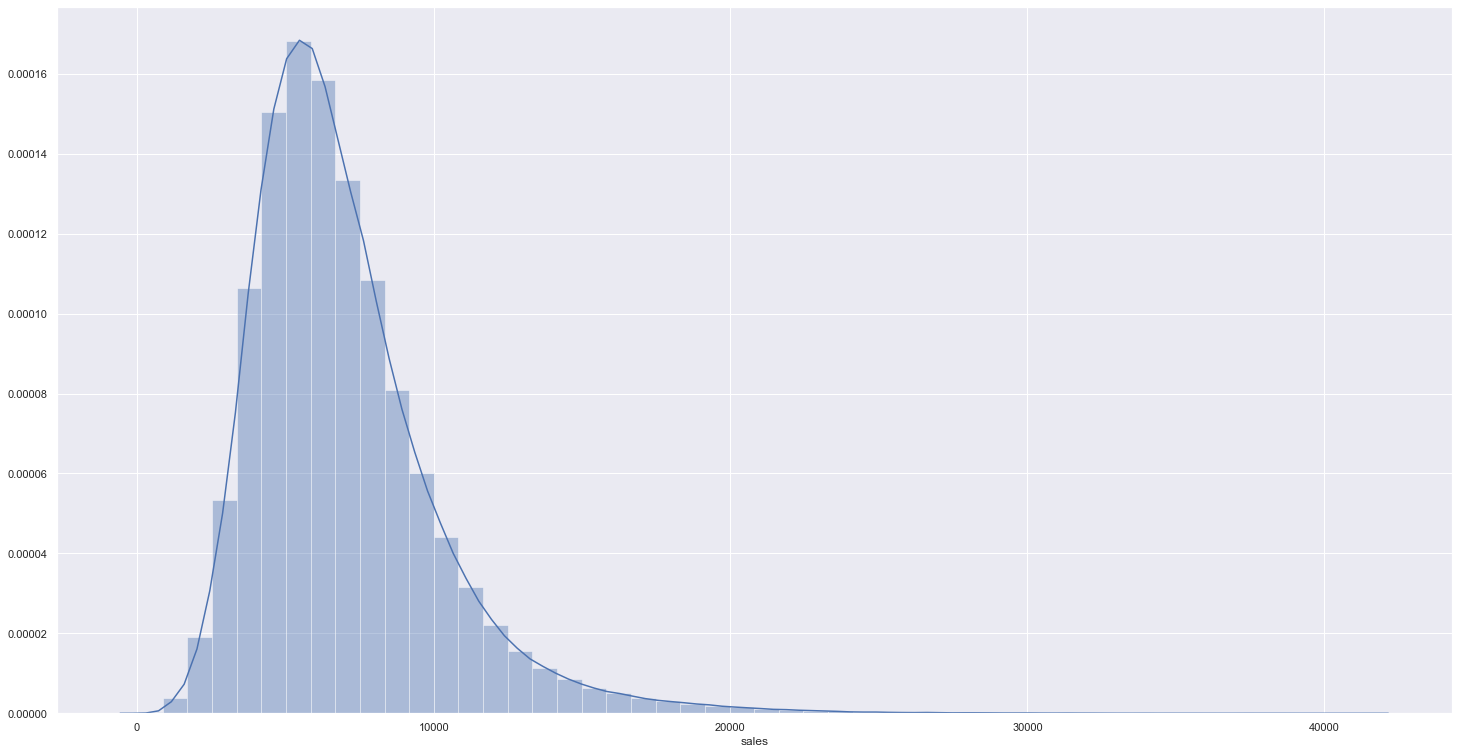

In [33]:
sns.distplot(df4['sales']);

### 4.1.2. Numerical Variable

In [34]:
print ('Os registros de vendas comecam em: {}'.format (df4['date'].min()))
print ('Os registros de vendas terminam em: {}'.format (df4['date'].max()))

Os registros de vendas comecam em: 2013-01-01 00:00:00
Os registros de vendas terminam em: 2015-07-31 00:00:00


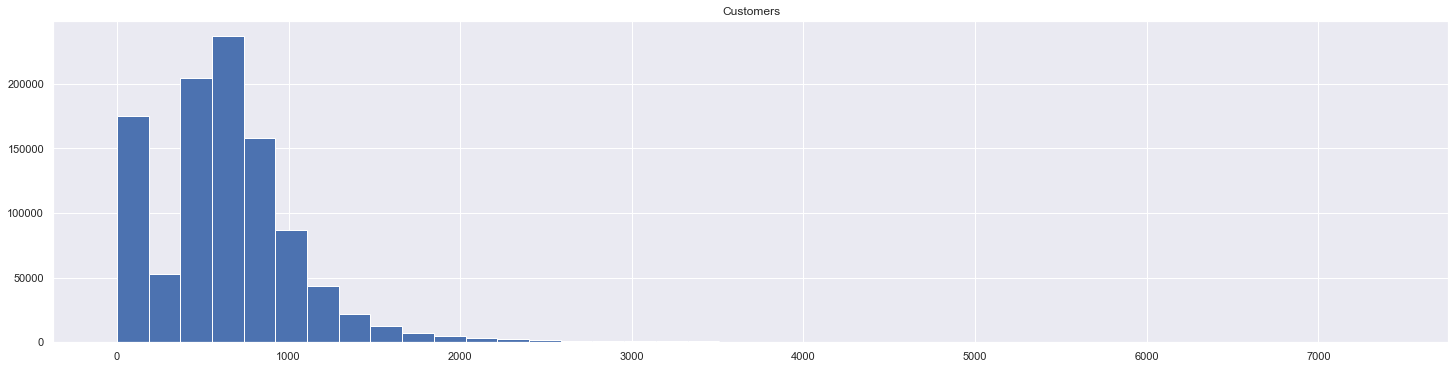

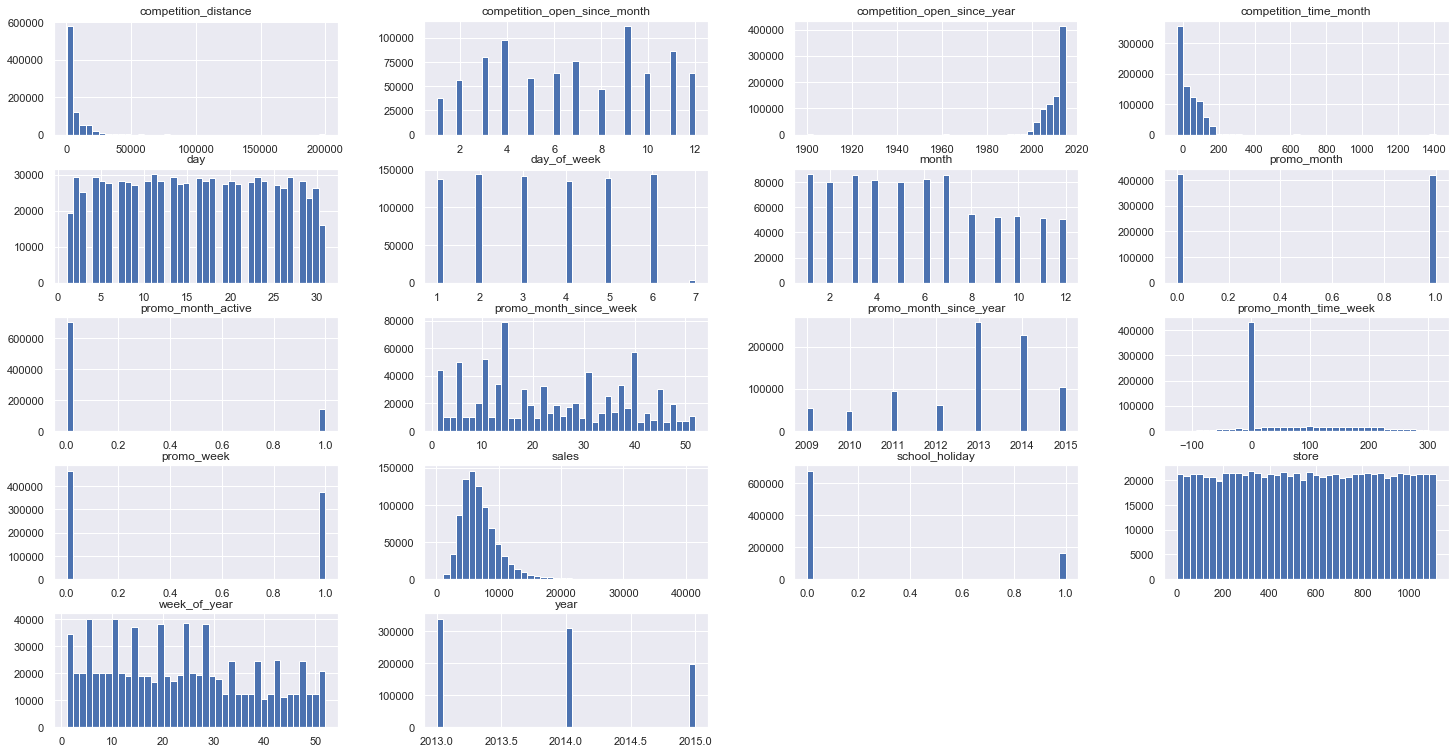

In [35]:
grid = GridSpec(2,1)
plt.subplot(grid[0,0])
df2['customers'].hist(bins = 40);
plt.title('Customers')

plt.subplot(grid[0,0])
num_attributes_2 = df4.select_dtypes( include = ['int64', 'float64'])
num_attributes_2.hist( bins = 40);

- #### Maior concentração de dados:

    - em distâncias menores (competidores estão próximos) - `competition_distance`;

    - em lojas concorrentes que foram abertas nos meses de abril e setembro -  `competition_open_since_month;`

    - em lojas concorrentes que foram abertas a partir de 2000 - `competition_open_since_year`;

    - em lojas que estão próximas a concorrentes que existem em poucos meses - `competition_time_month`;

    - no primeiro semestre, lembrando que os registros das vendas do último ano vão até julho - `month`;

    - entre 500 e 700 clientes frequentando as lojas - `customers`;

    - em dias que não são feriados escolares - `school_holiday`;

    - em lojas que não estão realizando promoção semanal - `promo_week`;

    - em lojas que não estão com as promoções mensais ativadas - `promo_month_active`;

    - em lojas que iniciaram a promoção mensal na semana 14 - `promo_month_since_week`;

    - em lojas que iniciaram a promoção mensal nos anos de 2013 e 2014 - `promo_month_since_year`;

    - em lojas que iniciaram a promoção mensal recentemente - `promo_month_time_week`.

---------------------------------------------------------------------------------------------------------------------------------------------------------

- #### Menor concentração de dados:

    - no domingo - `day_of_week`;
    - nos dias 1º e 31 - `days`.

### 4.1.3. Categorical Variable

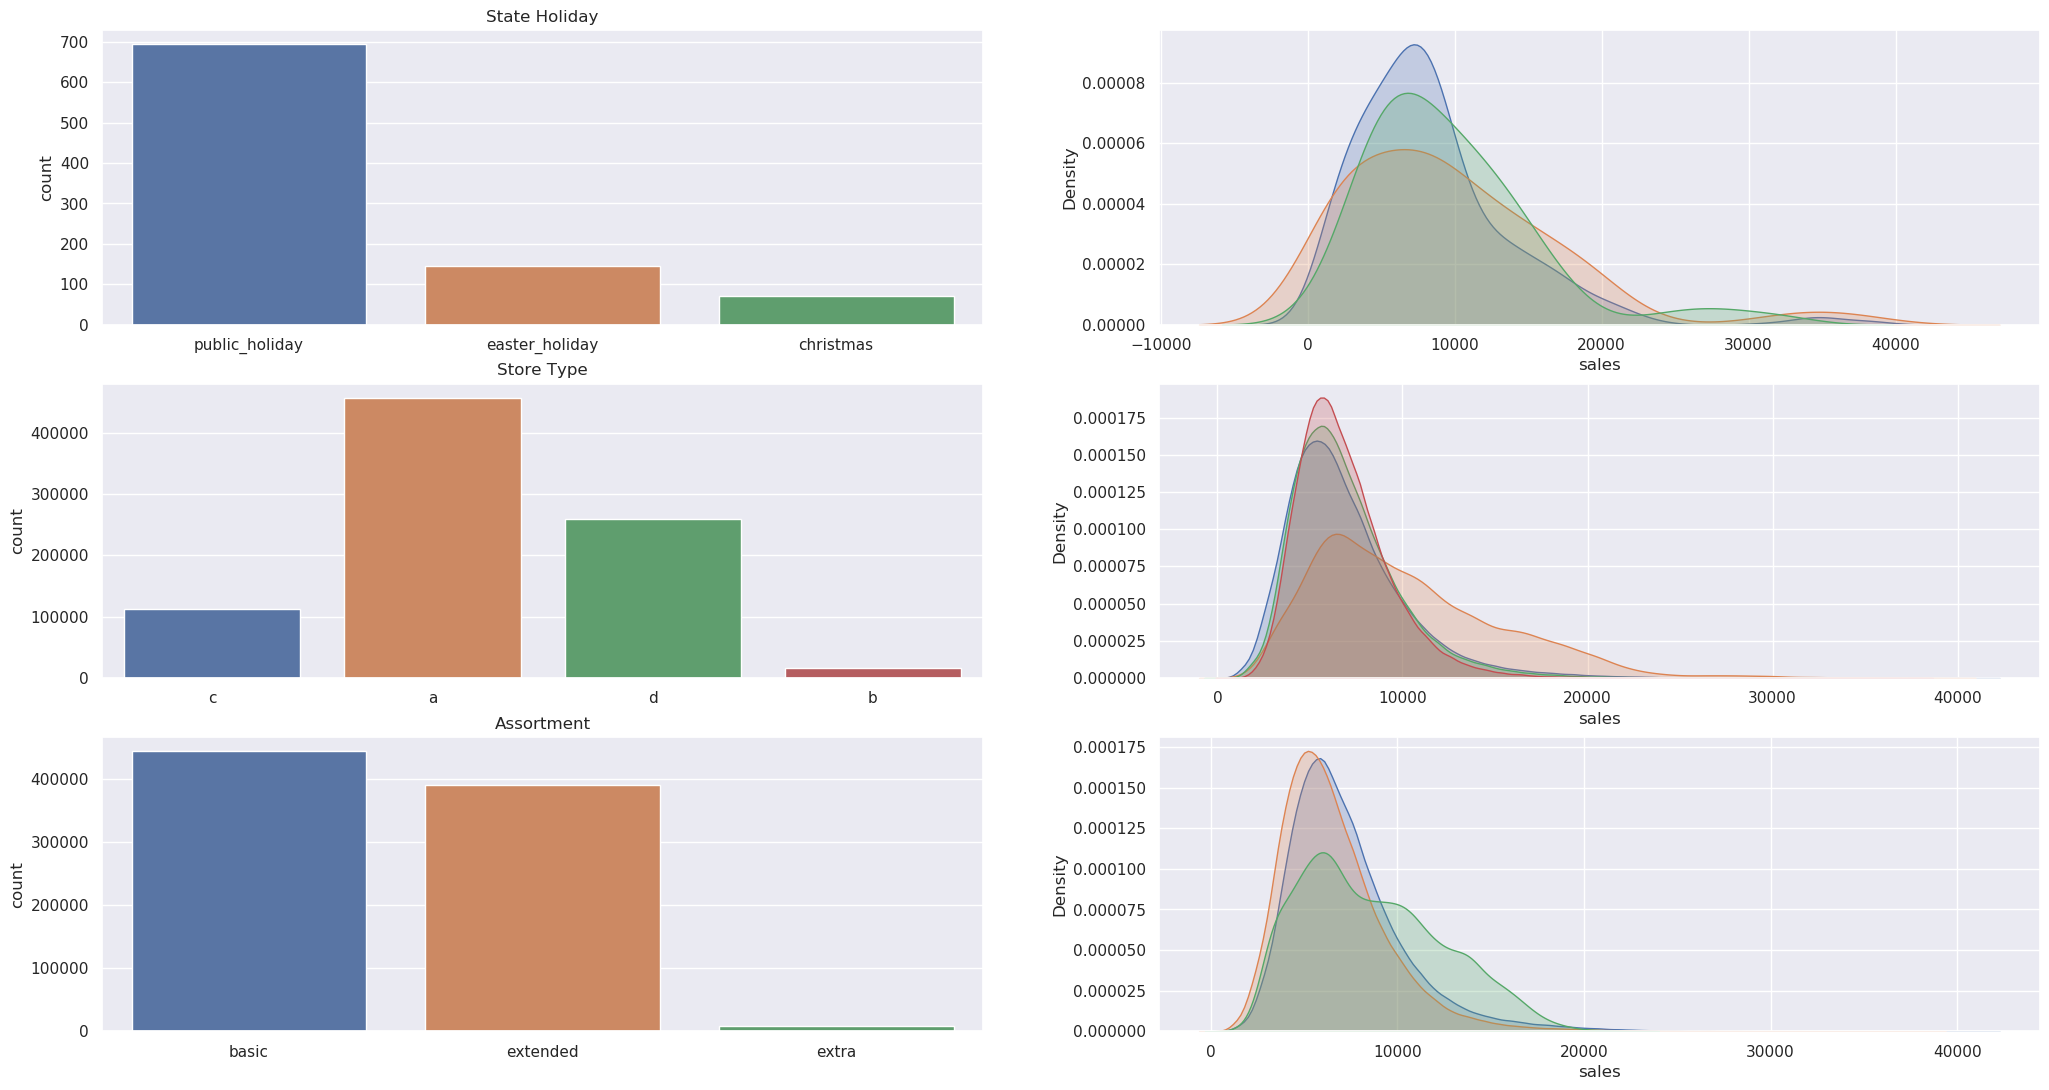

In [76]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
fig1 = sns.countplot( x = a['state_holiday'] );
fig1.title.set_text('State Holiday')
fig1.set(xlabel=None)

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True );
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True );
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True );

# store_type
plt.subplot( 3, 2, 3 )
fig2 = sns.countplot( x= df4['store_type'] );
fig2.title.set_text('Store Type')
fig2.set(xlabel=None)

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True );

# assortment
plt.subplot( 3, 2, 5 )
fig3 = sns.countplot( x = df4['assortment'] );
fig3.title.set_text('Assortment')
fig3.set(xlabel=None)

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True );
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True );
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True );

- #### state_holiday:

 - a = public_holiday:
    - com registros de vendas que concentram outros feriados do país, é o que apresenta a curva mais pontiguada, com dados concentrados entre 1 e 10 mil aprox.;

- b = easter_holiday:
    - apresentando uma curva mais achatada, pois a distribuição de dados tem um intervalo maior, com dados reunidos em +- 25 mil e uma menor frequência nos valores iniciais, comparado aos demais;


- c: christmas:
   - curva pontiaguda, com pontos de dados em até 18 mil. É o feriado com menor intervalo nas vendas, exibindo uma frequência de uns 35 mil aprox..

- #### store_type:

    - a: tipo de loja com mais registros de vendas, assemelhando-se com a loja c quanto a frequência de vendas. Inicia-se com o menor valor de vendas;
    
    - b: tipo de loja que diferente das demais, possui menos registros, mas há uma certa concentração de dados que se estendem até uns 20 mil;

    - d: tipo de loja com maior pico de vendas.

- #### assortment

    - a: basic - lojas com produtos básicos
    - b: extra - lojas com uma certa variedade de produtos
    - c : extended - lojas com mais sortimentos de produtos


 - basic e extendend: exibem uma certa semelhança na distribuição de dados, porém, basic apresenta bastante outliers;

 - extra: apresentam menos registros e vendas.

## 4.2. Análise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais

**FALSA** - Lojas com MAIOR SORTIMENTO vendem MENOS.

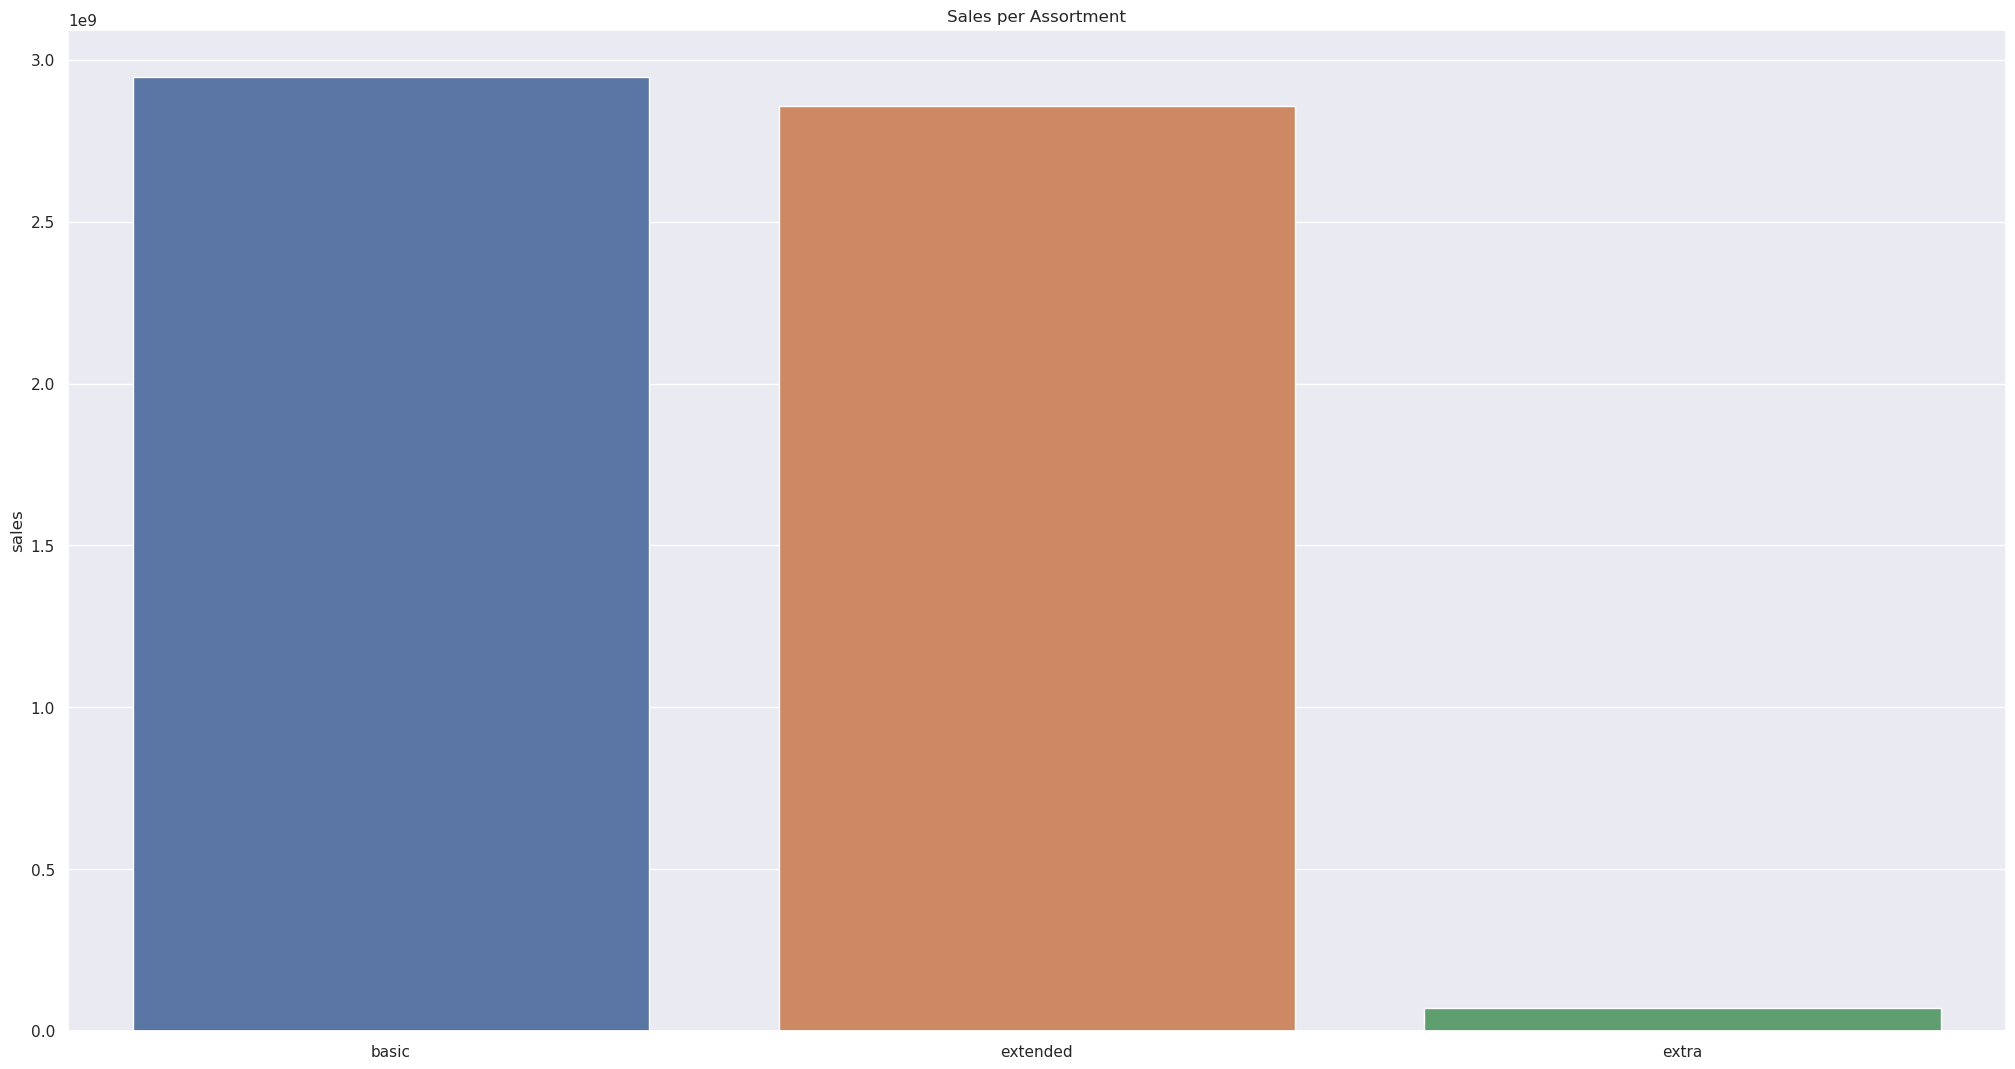

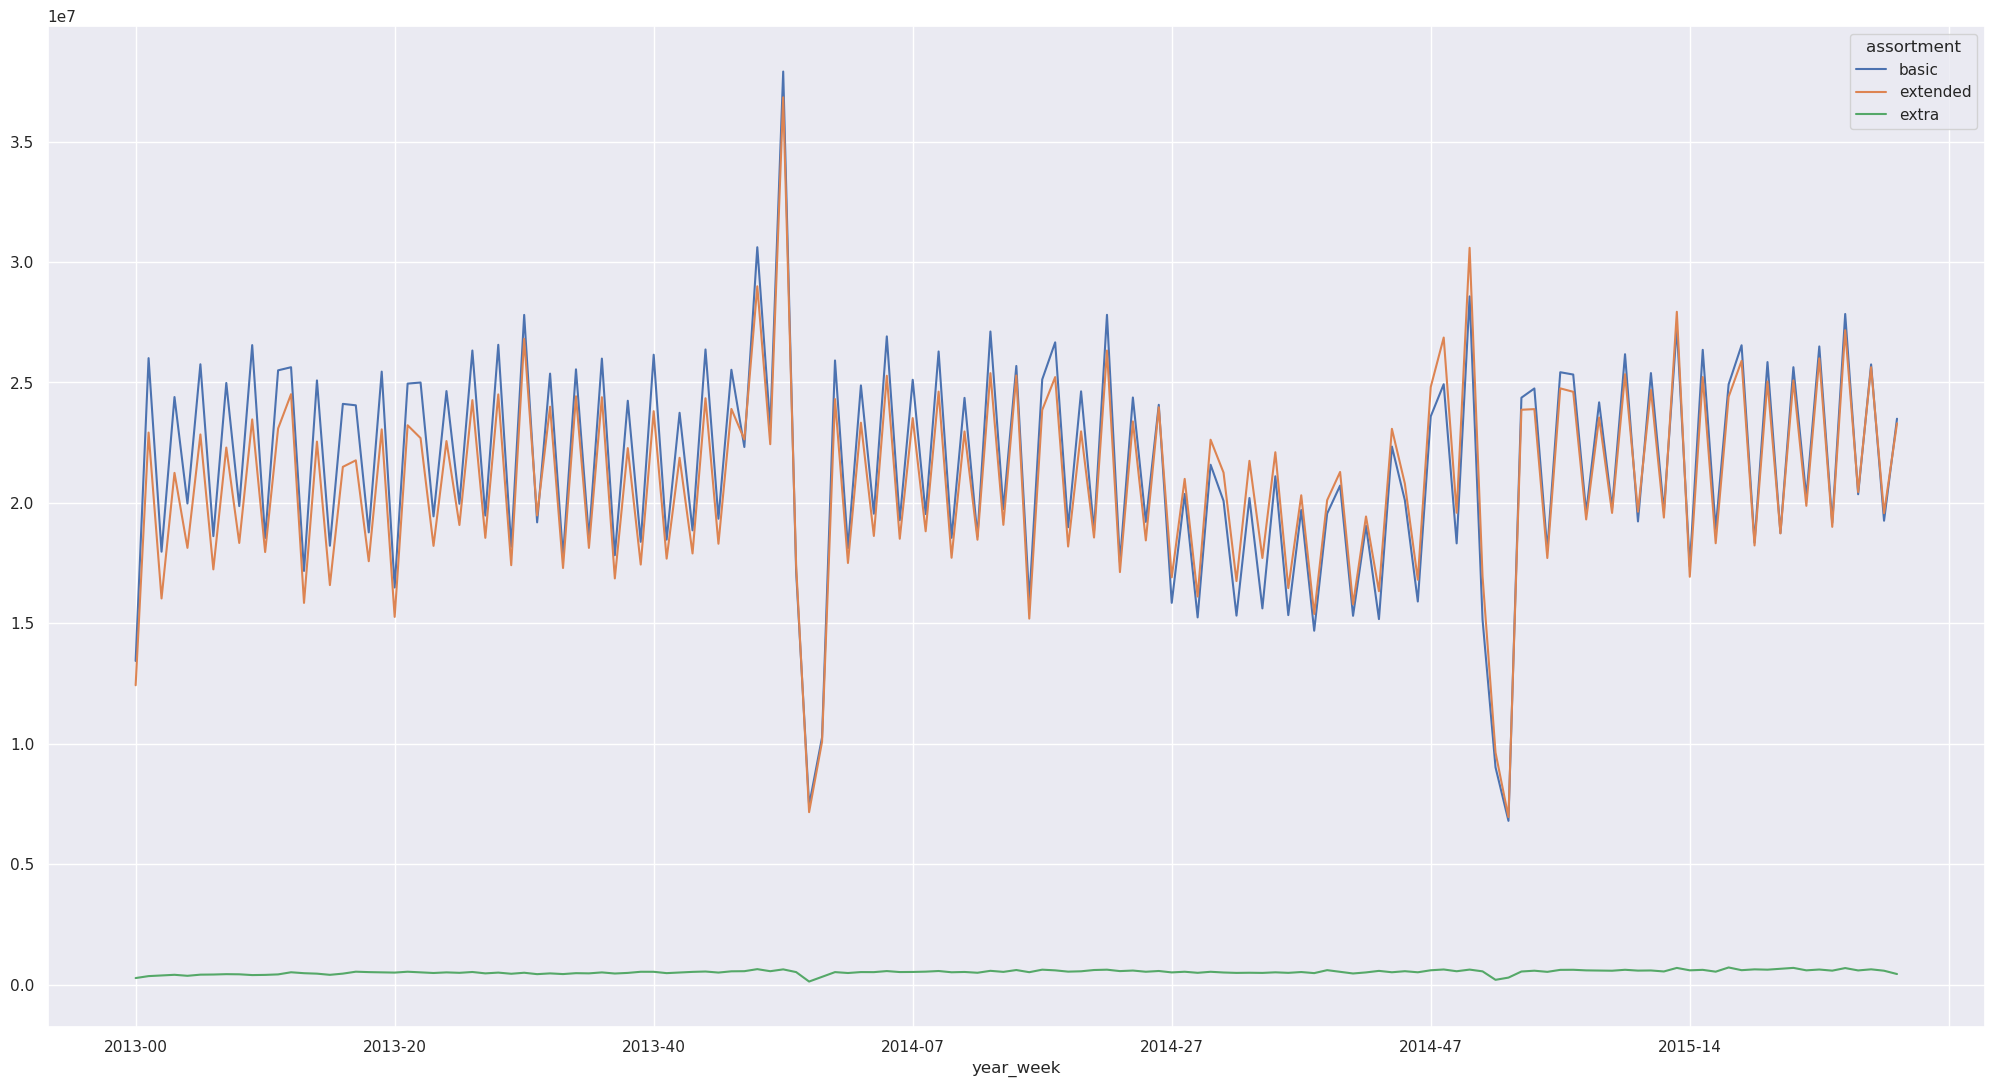

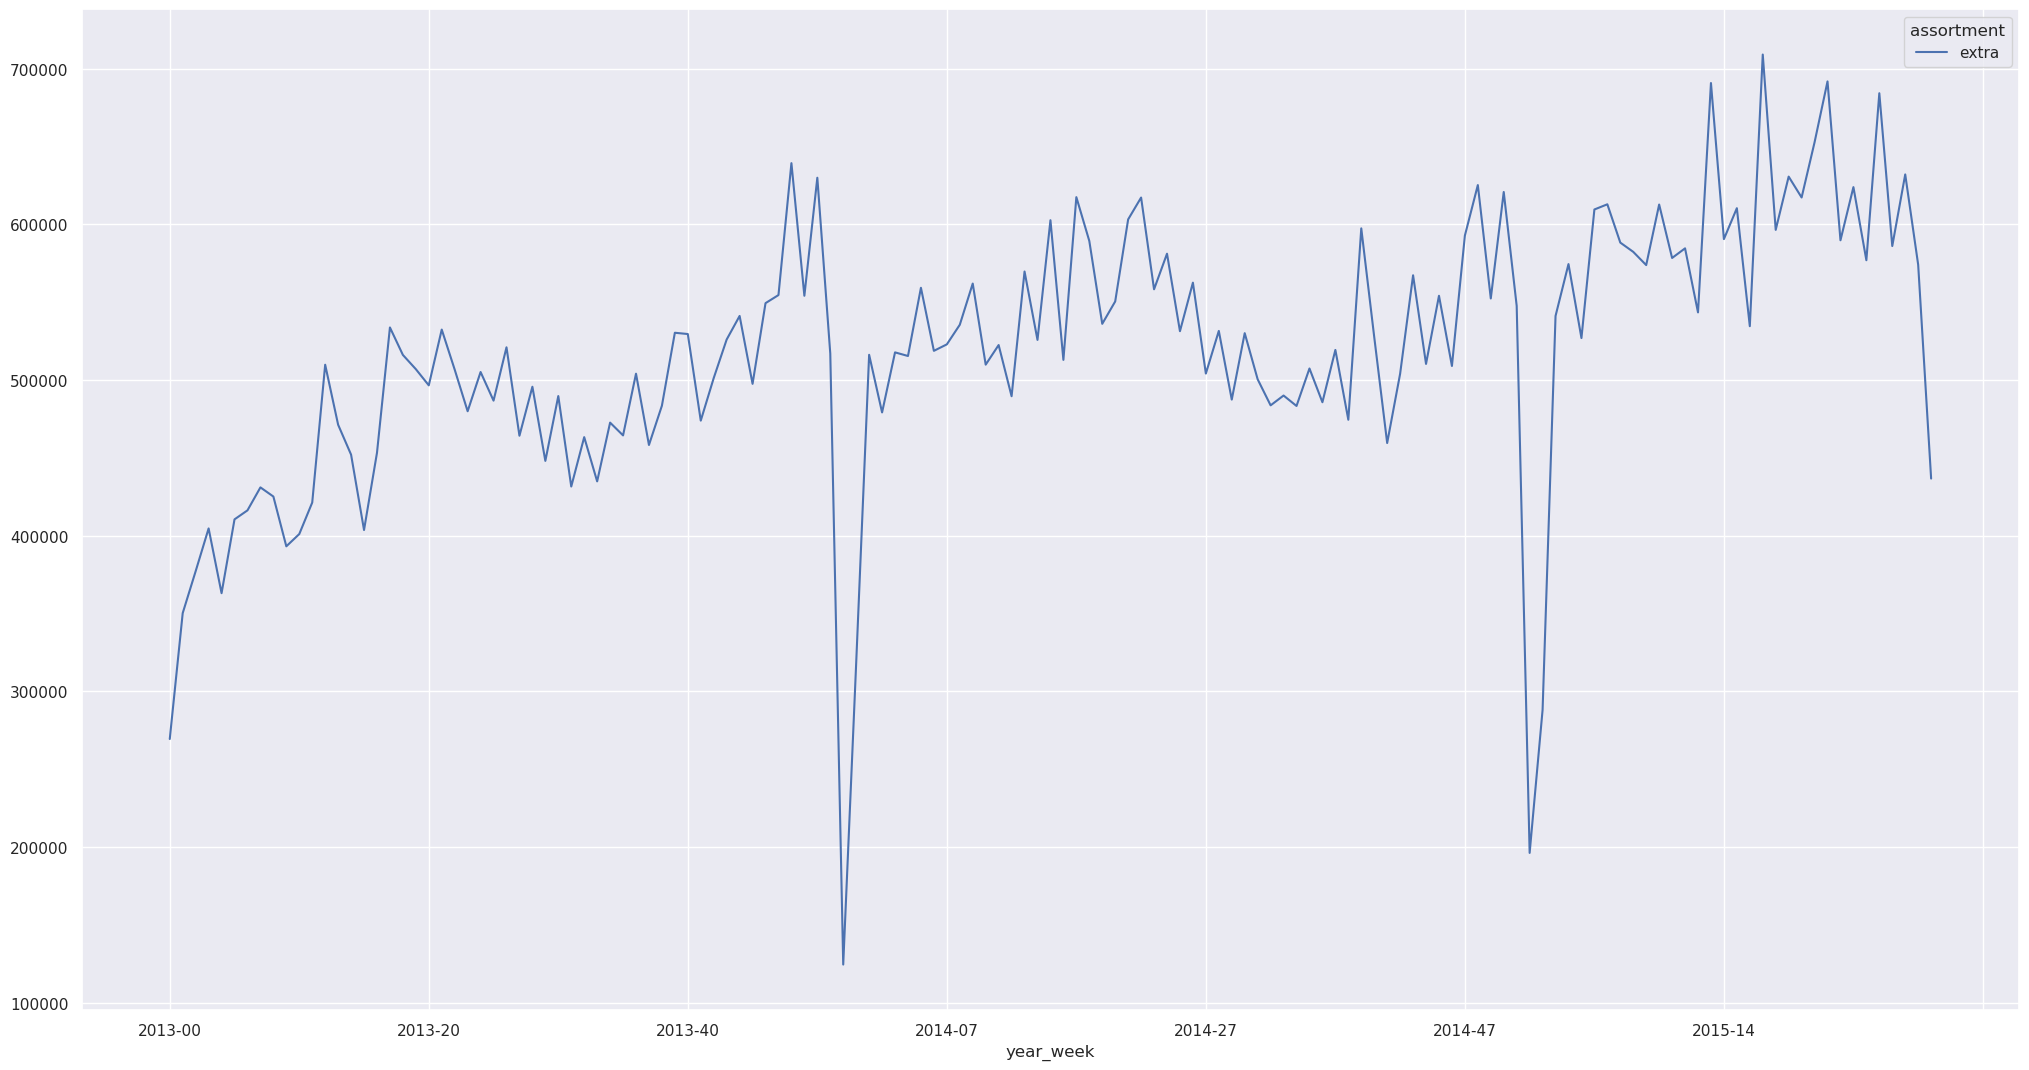

In [77]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
g1 = sns.barplot (x= 'assortment', y= 'sales', data= aux1);
g1.set(xlabel=None)
plt.title('Sales per Assortment')

# verificando possiveis mudancas de comportamento ao longo do tempo
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot_table('sales', index='year_week', columns='assortment').plot();

# verificando somente a categoria extra
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSA** - Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

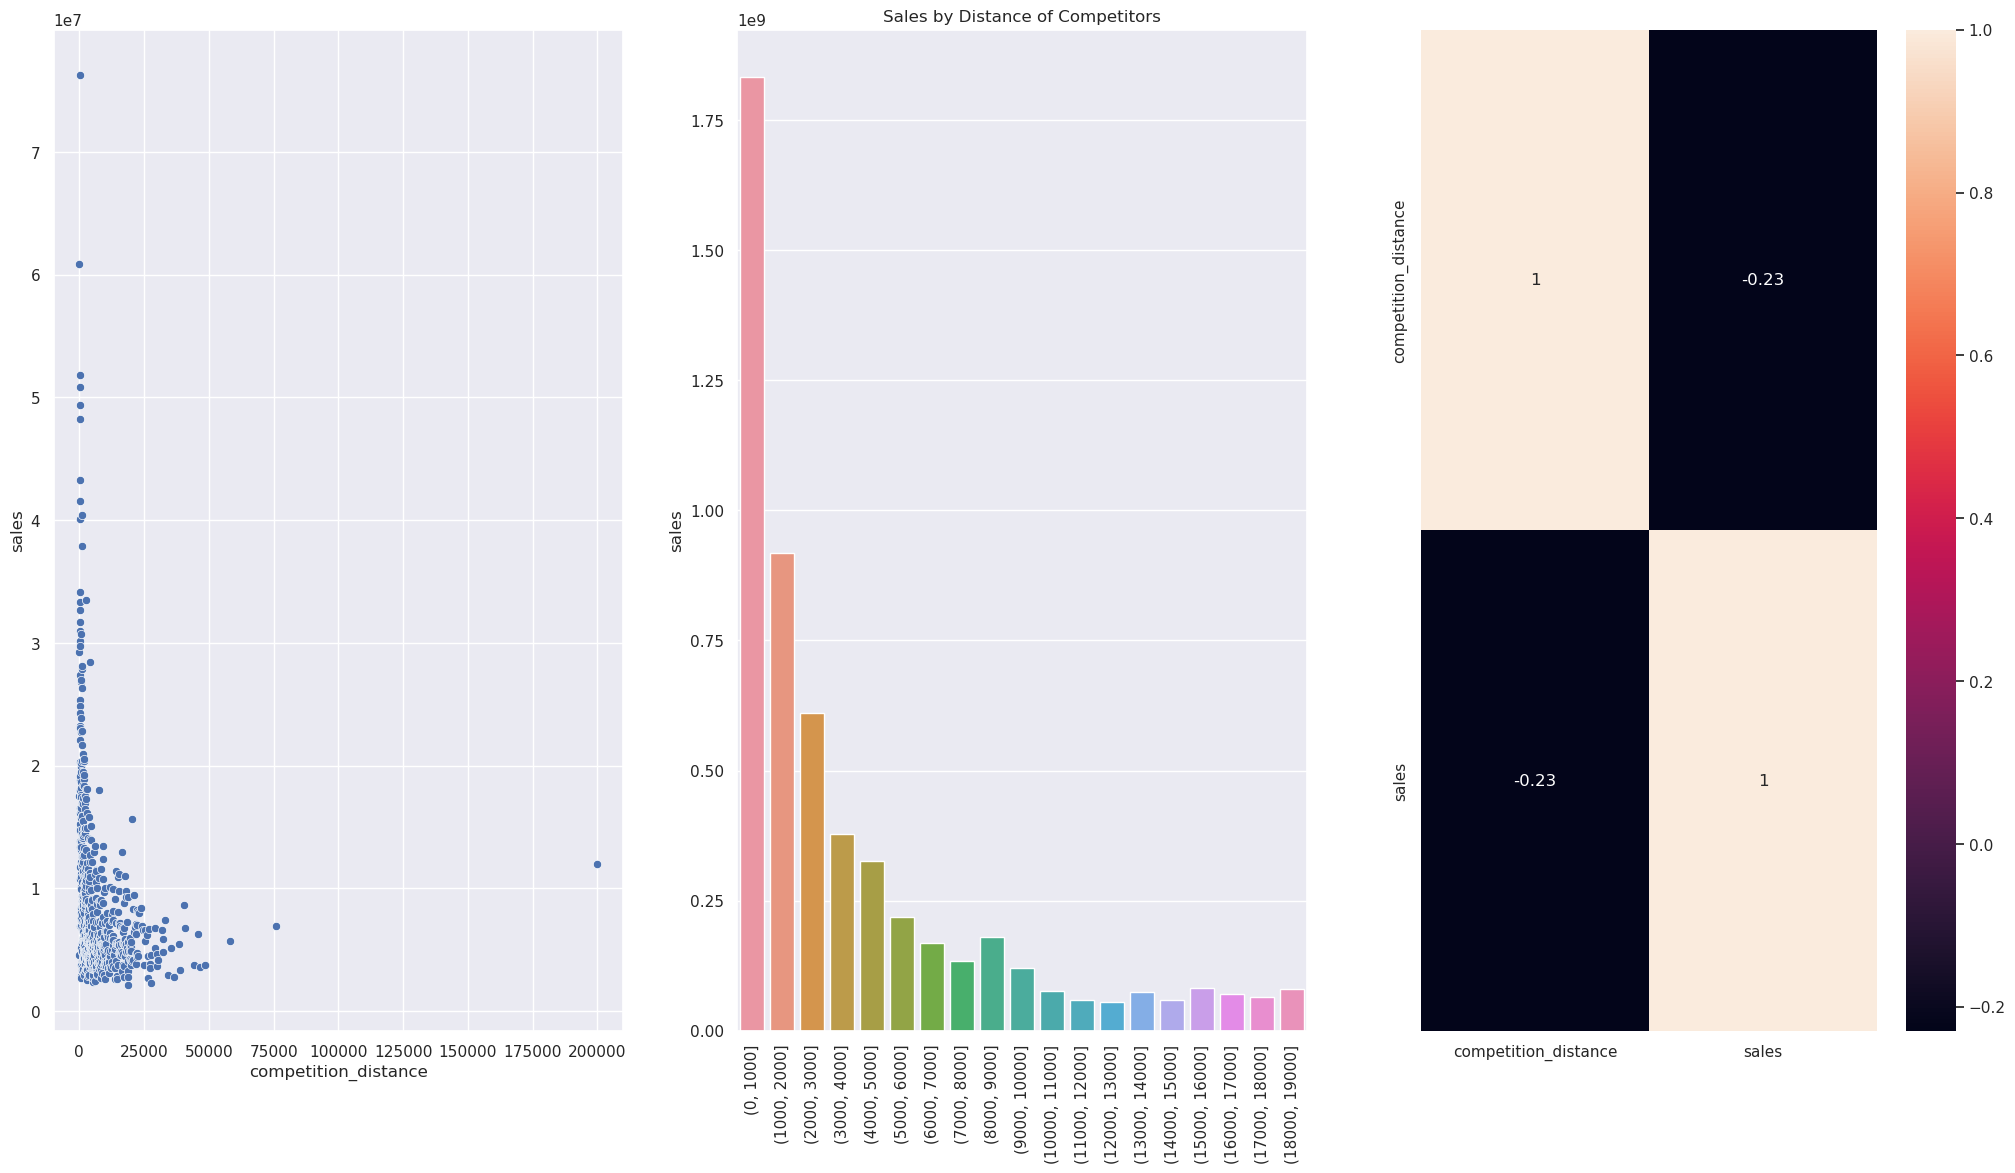

In [78]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()


plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );


plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
g1 = sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
g1.set(xlabel=None)
plt.xticks( rotation=90 );
plt.title('Sales by Distance of Competitors');

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H3.** Lojas com competidores há mais tempo deveriam vendem mais.

**FALSA** - Lojas com COMPETIDORES HÁ MAIS TEMPO vendem MENOS.

Legenda:

- valores > 0: concorrentes existem ha mais de um mes

- valores < 0: concorrentes surgiram meses apos a data de registro de vendas

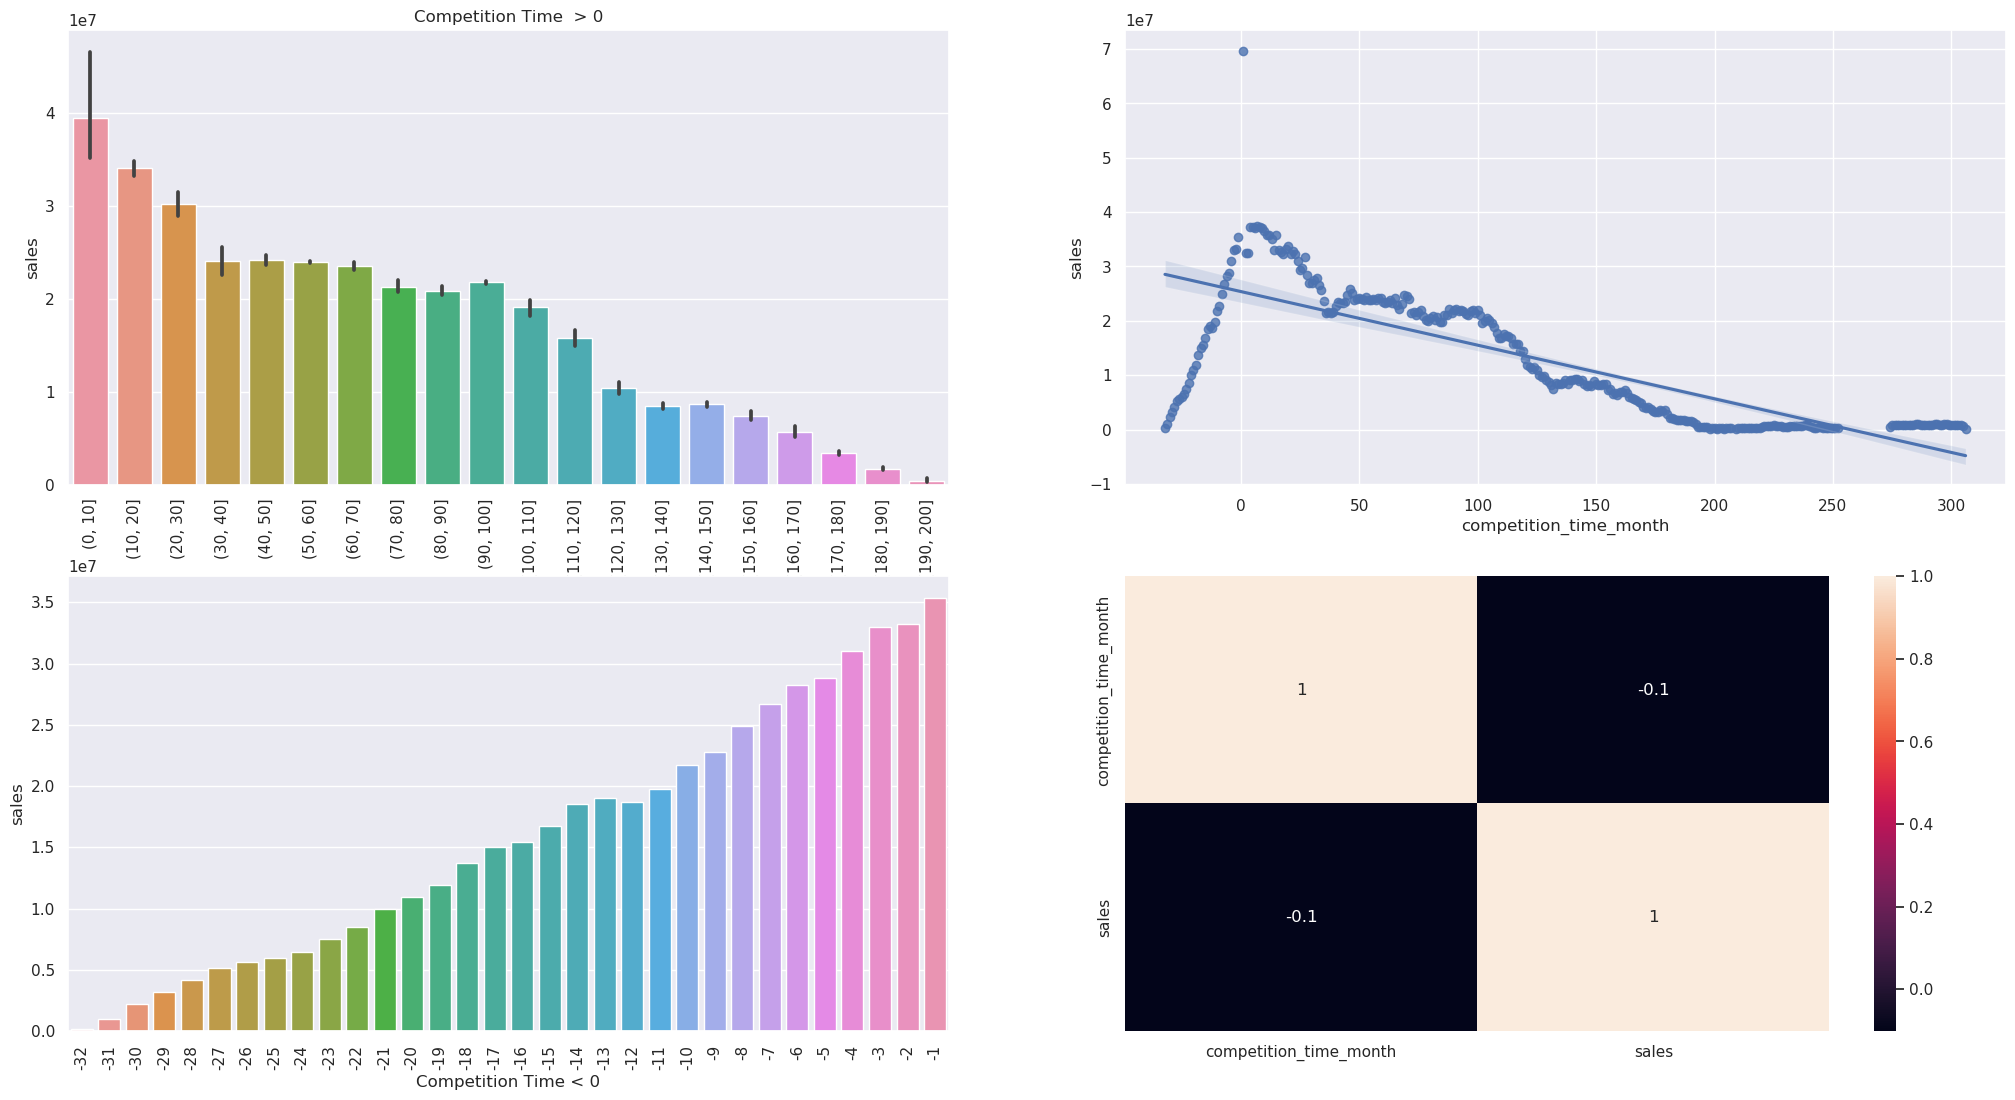

In [79]:
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
aux2 = aux1[aux1['competition_time_month'] > 0]
bins = list( np.arange( 0, 210, 10) )
aux2['competition_time_month_binned'] = pd.cut( aux2['competition_time_month'], bins=bins )
sns.barplot( x='competition_time_month_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.title('Competition Time  > 0')

plt.subplot( 2, 2, 3 )
aux3 = aux1[aux1['competition_time_month'] < 0]
sns.barplot( x='competition_time_month', y='sales', data = aux3 );
plt.xticks( rotation=90 );
plt.xlabel('Competition Time < 0')

plt.subplot( 2, 2, 2 )
aux4 = aux1[(aux1['competition_time_month'] != 0) & (aux1['competition_time_month'] < 500)]
sns.regplot(x='competition_time_month', y= 'sales', data = aux4);

plt.subplot( 2, 2, 4 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );

### **H4.** Lojas que participam das duas promoções deveriam vender mais.

**FALSA** - Lojas que participam das duas promoções (semanal e mensal) vendem menos

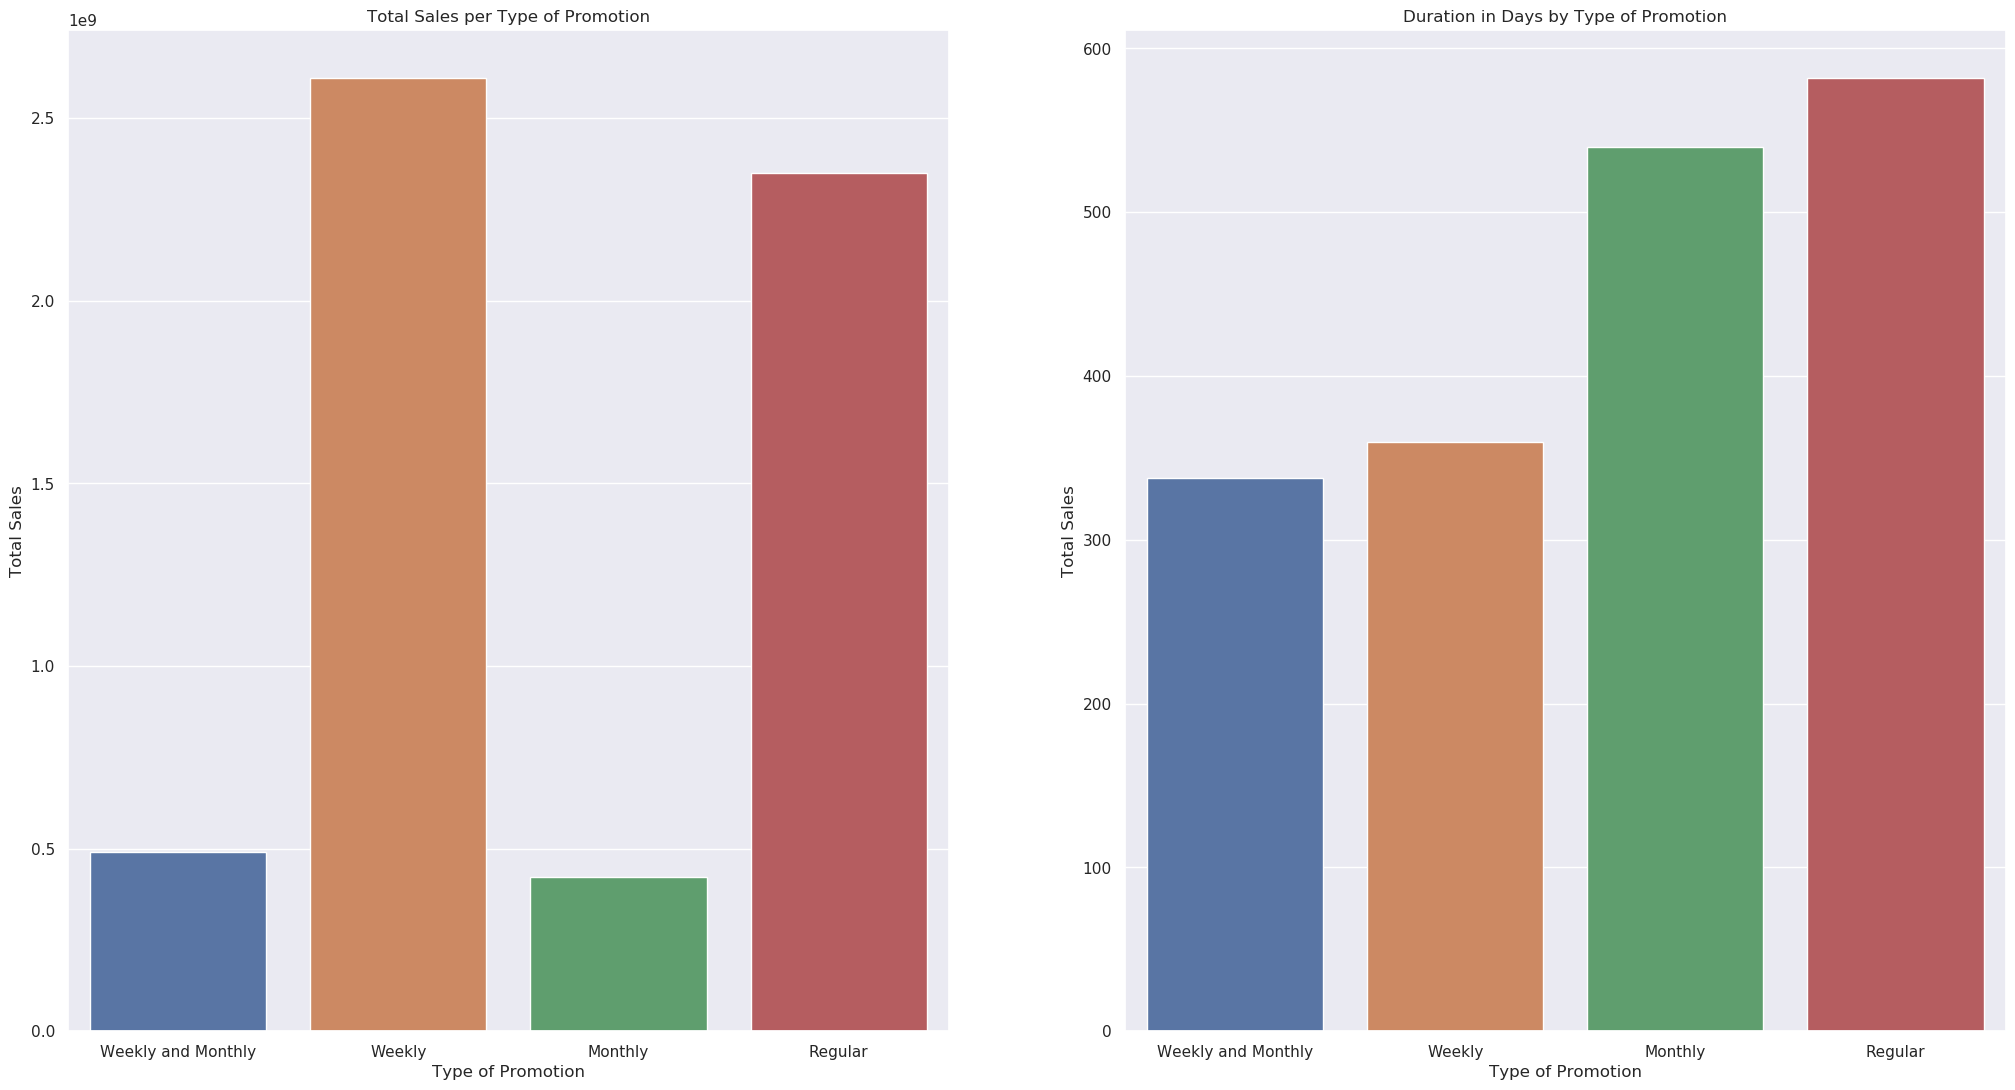

In [80]:
grid = GridSpec(1,2)


plt.subplot(grid[0,0])
soma_promo1 = df4[(df4['promo_week'] == 1) & (df4['promo_month_active'] == 1)] ['sales'].sum() #semanal e mensal
soma_promo2 = df4[(df4['promo_week'] == 1) & (df4['promo_month_active'] == 0)] ['sales'].sum() #semanal
soma_promo3 = df4[(df4['promo_week'] == 0) & (df4['promo_month_active'] == 1)] ['sales'].sum() #mensal
soma_promo4 = df4[(df4['promo_week'] == 0) & (df4['promo_month_active'] == 0)] ['sales'].sum() #regular

dados = {'Type of Promotion': ['Weekly and Monthly', 'Weekly', 'Monthly', 'Regular'],
         'Total Sales': [soma_promo1, soma_promo2, soma_promo3, soma_promo4]}

df_promo = pd.DataFrame(dados)

sns.barplot(x='Type of Promotion', y='Total Sales', data=df_promo)
plt.title('Total Sales per Type of Promotion');


plt.subplot(grid[0,1])
count_promo1 = df4[(df4['promo_week'] == 1) & (df4['promo_month_active'] == 1)] [['date']].groupby('date').count().reset_index() #semanal e mensal
count_promo2 = df4[(df4['promo_week'] == 1) & (df4['promo_month_active'] == 0)] [['date']].groupby('date').count().reset_index() #semanal
count_promo3 = df4[(df4['promo_week'] == 0) & (df4['promo_month_active'] == 1)] [['date']].groupby('date').count().reset_index()#mensal
count_promo4 = df4[(df4['promo_week'] == 0) & (df4['promo_month_active'] == 0)] [['date']].groupby('date').count().reset_index() #regular

count_promo1 = count_promo1['date'].count()
count_promo2 = count_promo2['date'].count()
count_promo3 = count_promo3['date'].count()
count_promo4 = count_promo4['date'].count()


dados = {'Type of Promotion': ['Weekly and Monthly', 'Weekly', 'Monthly', 'Regular'],
         'Total Sales': [count_promo1, count_promo2, count_promo3, count_promo4]}

df_promo = pd.DataFrame(dados)

sns.barplot(x='Type of Promotion', y='Total Sales', data=df_promo)
plt.title('Duration in Days by Type of Promotion');


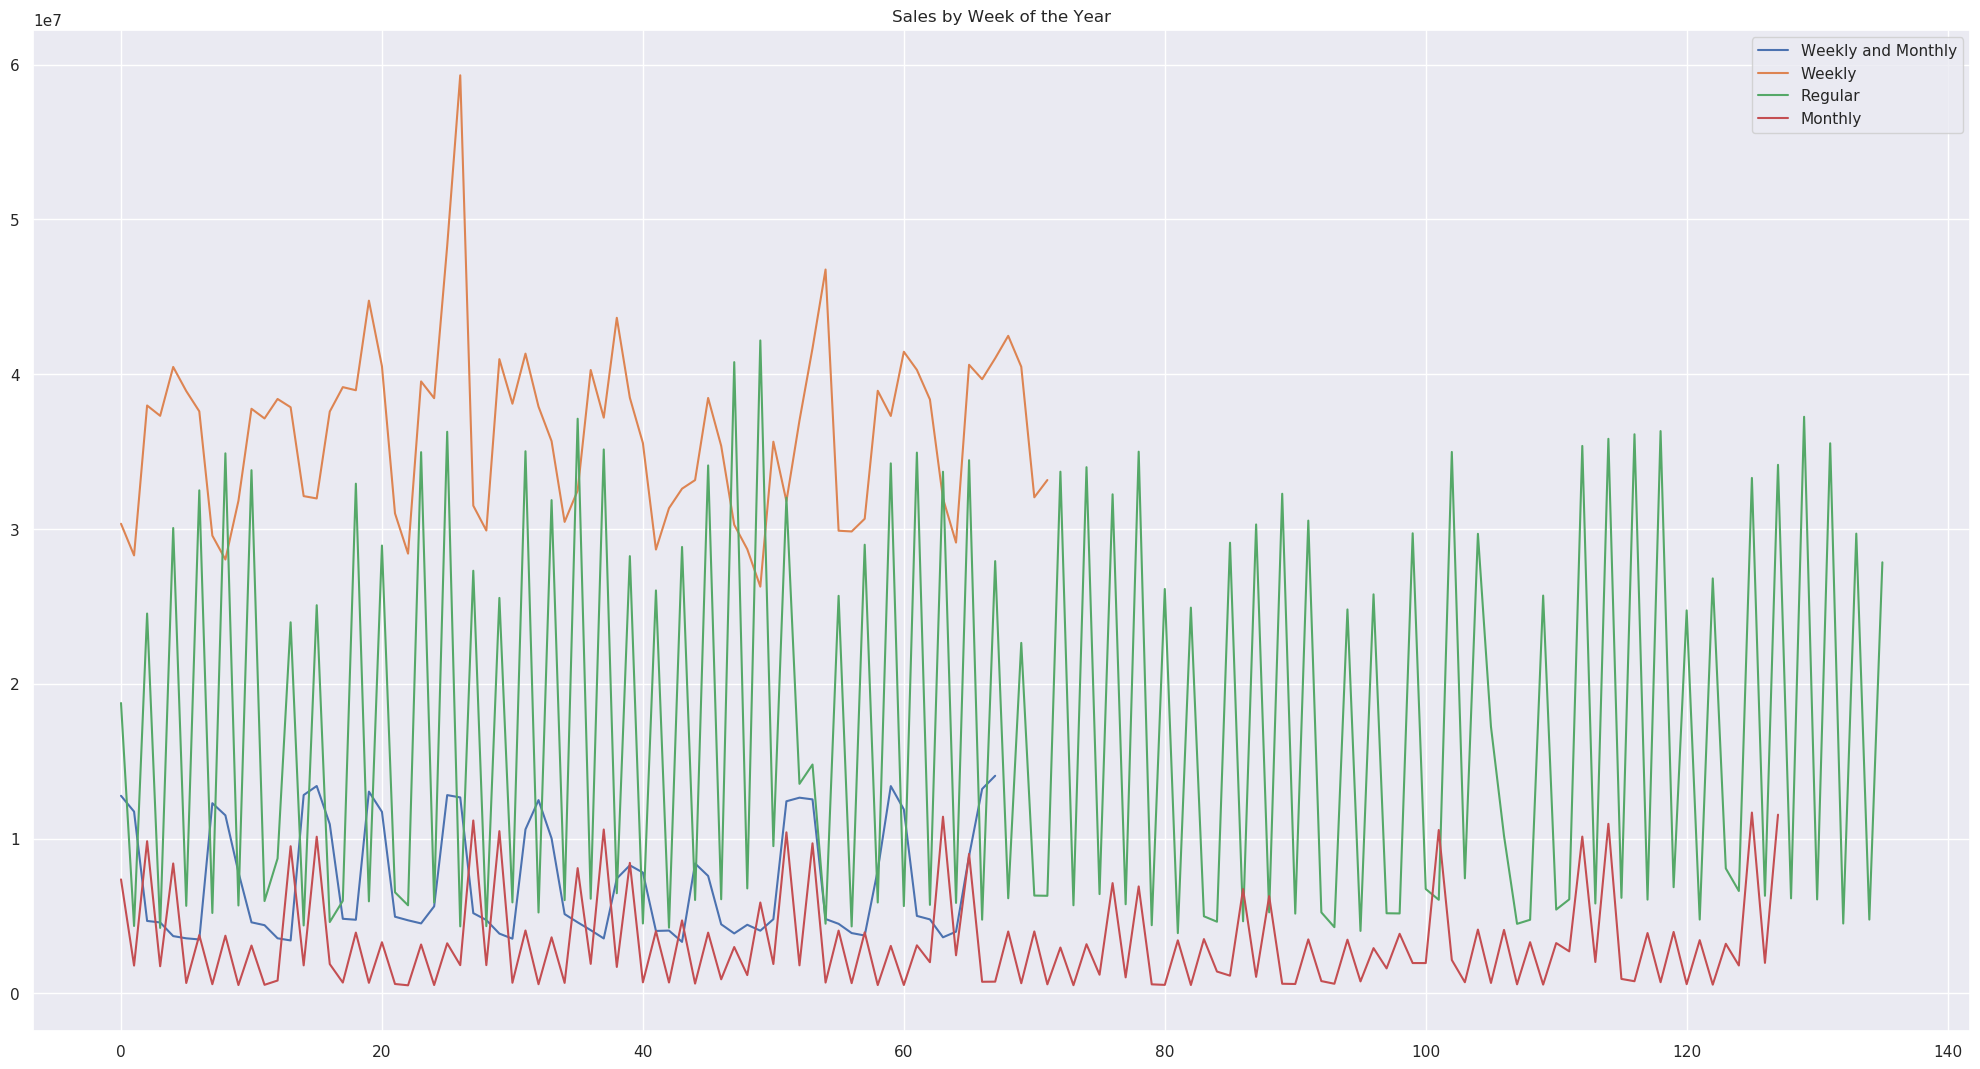

In [81]:
aux3 = df4[(df4['promo_week'] == 1) & (df4['promo_month_active'] == 1)] [['year_week', 'sales']].groupby('year_week').sum().reset_index();
ax = aux3.plot()

aux4 = df4[(df4['promo_week'] == 1) & (df4['promo_month_active'] == 0)] [['year_week', 'sales']].groupby('year_week').sum().reset_index();
aux4.plot(ax=ax)

aux5 = df4[(df4['promo_week'] == 0) & (df4['promo_month_active'] == 0)] [['year_week', 'sales']].groupby('year_week').sum().reset_index();
aux5.plot(ax=ax)

aux6 = df4[(df4['promo_week'] == 0) & (df4['promo_month_active'] == 1)] [['year_week', 'sales']].groupby('year_week').sum().reset_index();
aux6.plot(ax=ax)

# ax.legend(labels = ['Regular', 'Monthly']);

ax.legend(labels = ['Weekly and Monthly', 'Weekly', 'Regular', 'Monthly']);

plt.title('Sales by Week of the Year');

### **H5.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**Falsa** - Lojas abertas DURANTE O FERIADO DE NATAL vendem MENOS.


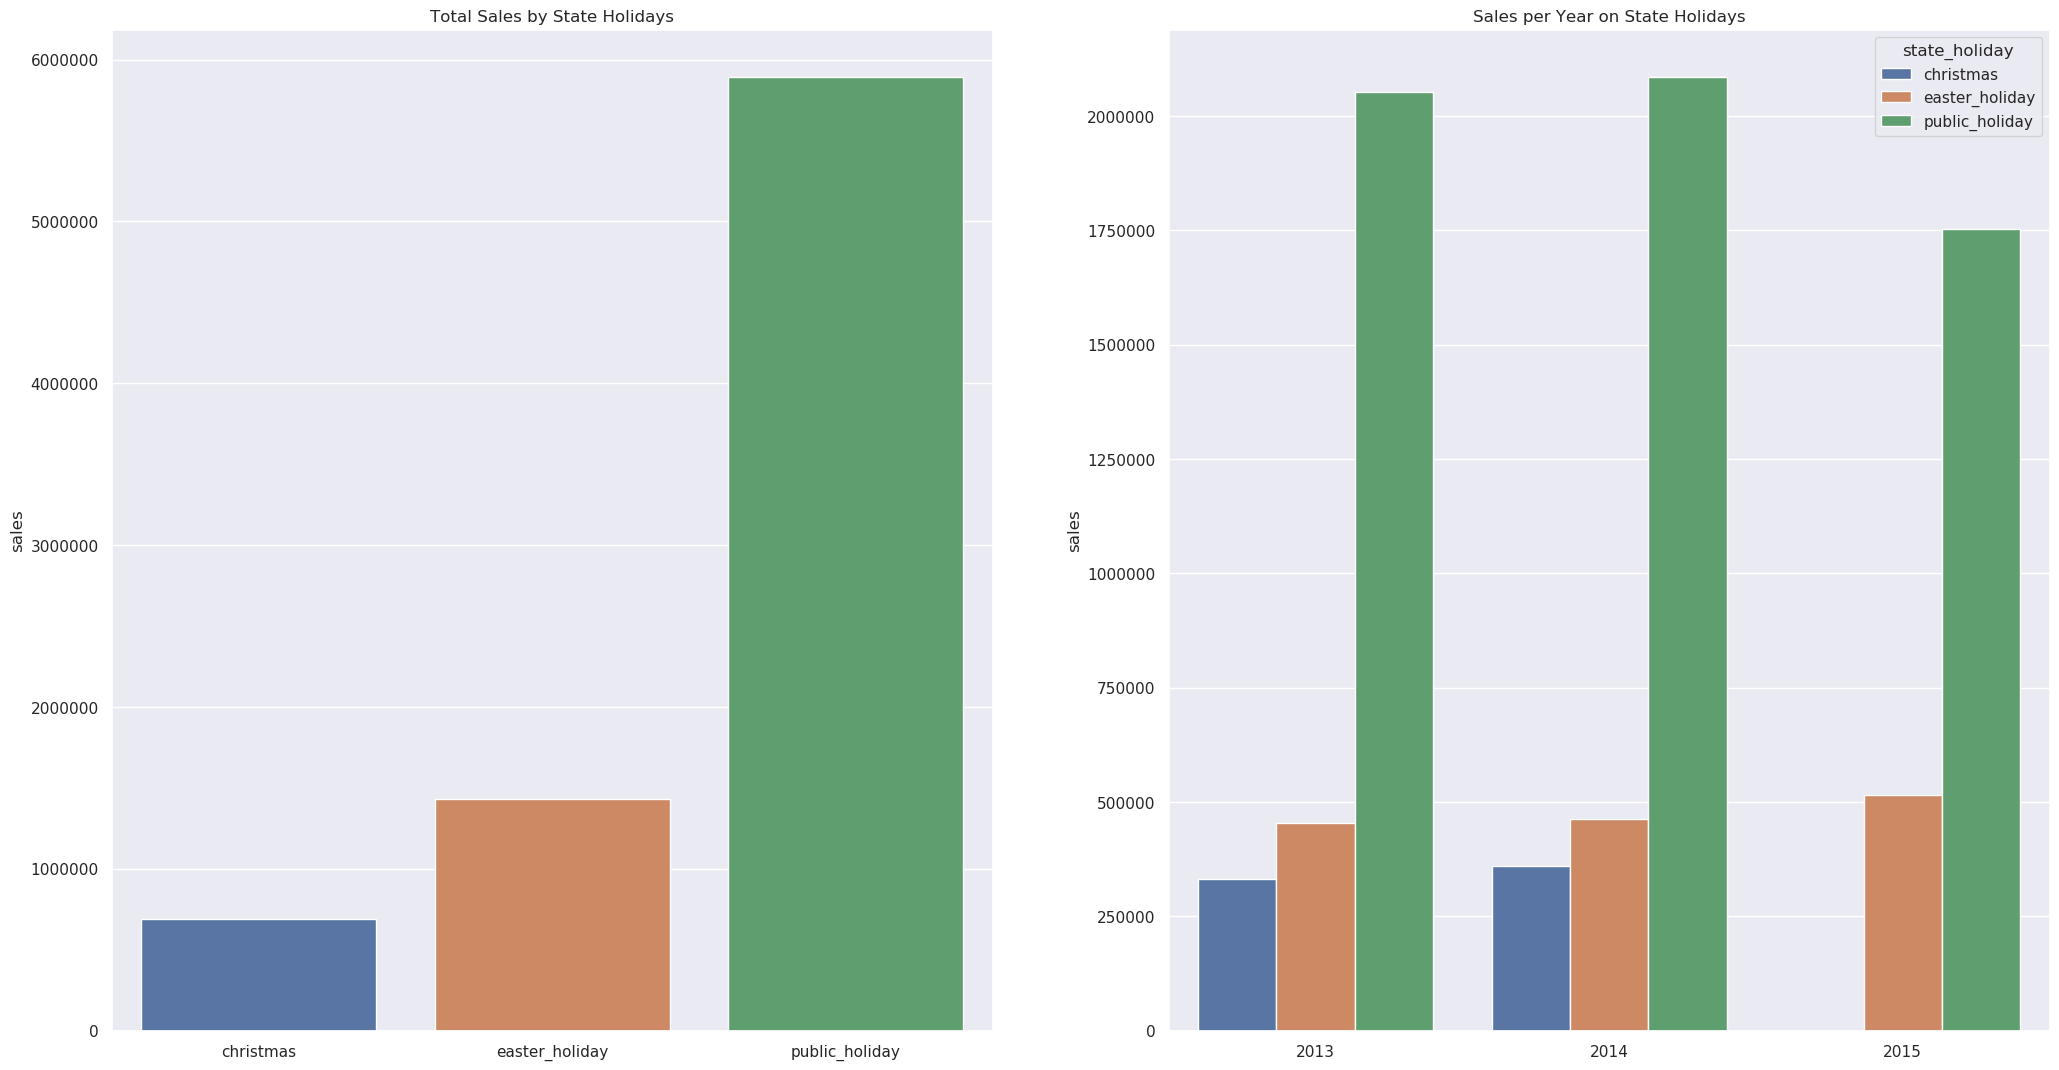

In [82]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
g1 = sns.barplot(x='state_holiday', y= 'sales', data=aux1);
g1.set(xlabel=None)
plt.title('Total Sales by State Holidays');

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
g2 = sns.barplot(x='year', y='sales', hue = 'state_holiday', data=aux2);
g2.set(xlabel=None)
plt.title('Sales per Year on State Holidays');


### **H6.** Lojas deveriam vender mais ao longo dos anos.

**FALSA** - As lojas NÃO VENDEM MAIS ao longo dos anos.

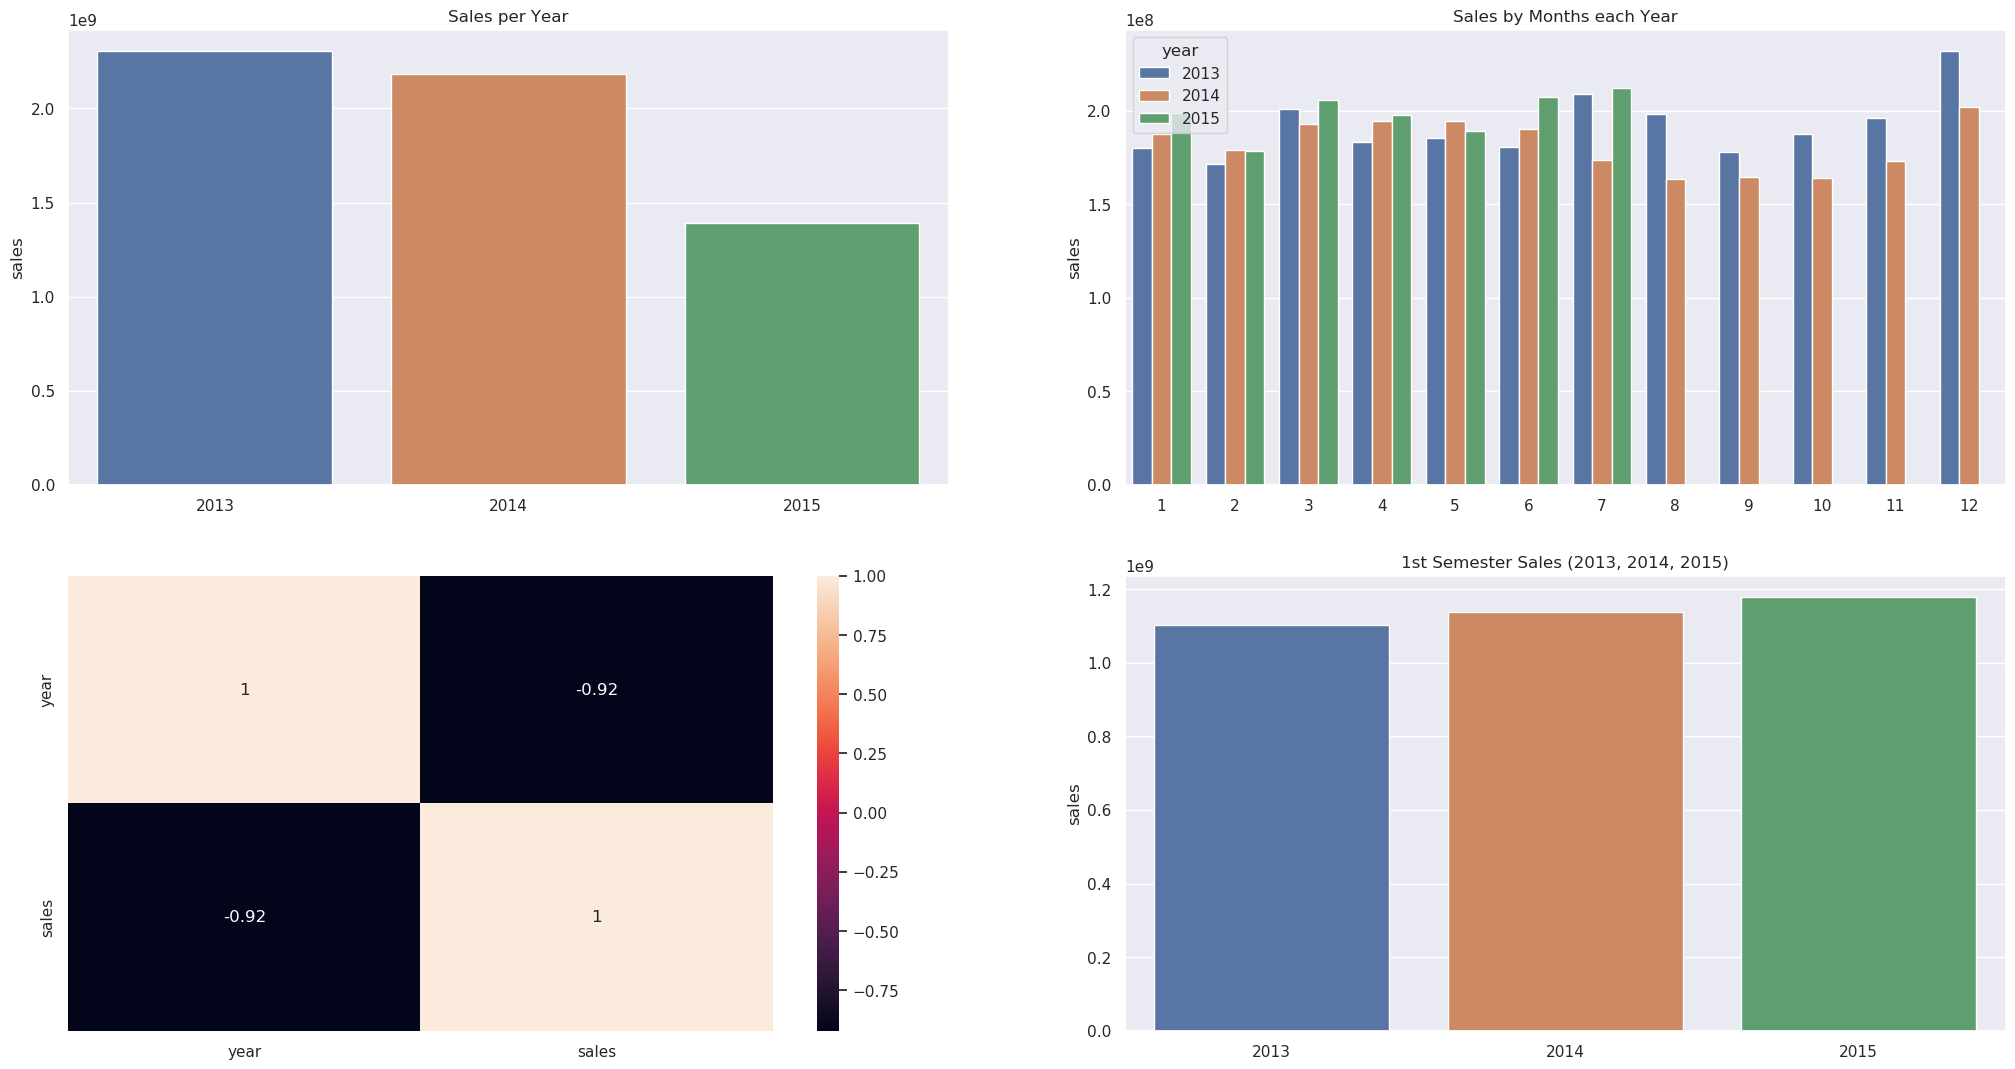

In [83]:
grid = GridSpec(2,2)

#ano
plt.subplot(grid[0,0])

aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
g1 = sns.barplot(x='year', y='sales', data= aux1);
g1.set(xlabel=None)
plt.title('Sales per Year');


#meses
plt.subplot(grid[0,1])
aux2 = df4[['month','year', 'sales']].groupby(['month','year']).sum().reset_index()
g2 = sns.barplot(x='month', y='sales', hue = 'year', data=aux2);
g2.set(xlabel=None)
plt.title('Sales by Months each Year');

# semestre
plt.subplot(grid[1,0])
sns.heatmap(aux1.corr (method='pearson'), annot=True);

plt.subplot(grid[1,1])
aux3 = df4[df4['month'] <= 6][['year', 'sales']].groupby(['year']).sum().reset_index()
g3 = sns.barplot(x='year', y= 'sales', data = aux3);
g3.set(xlabel=None)
plt.title('1st Semester Sales (2013, 2014, 2015)');



### **H7.** Lojas deveriam vender mais na primeira quinzena de cada mês.

**VERDADEIRA** - As lojas VENDEM MAIS na primeira quinzena de cada mês.

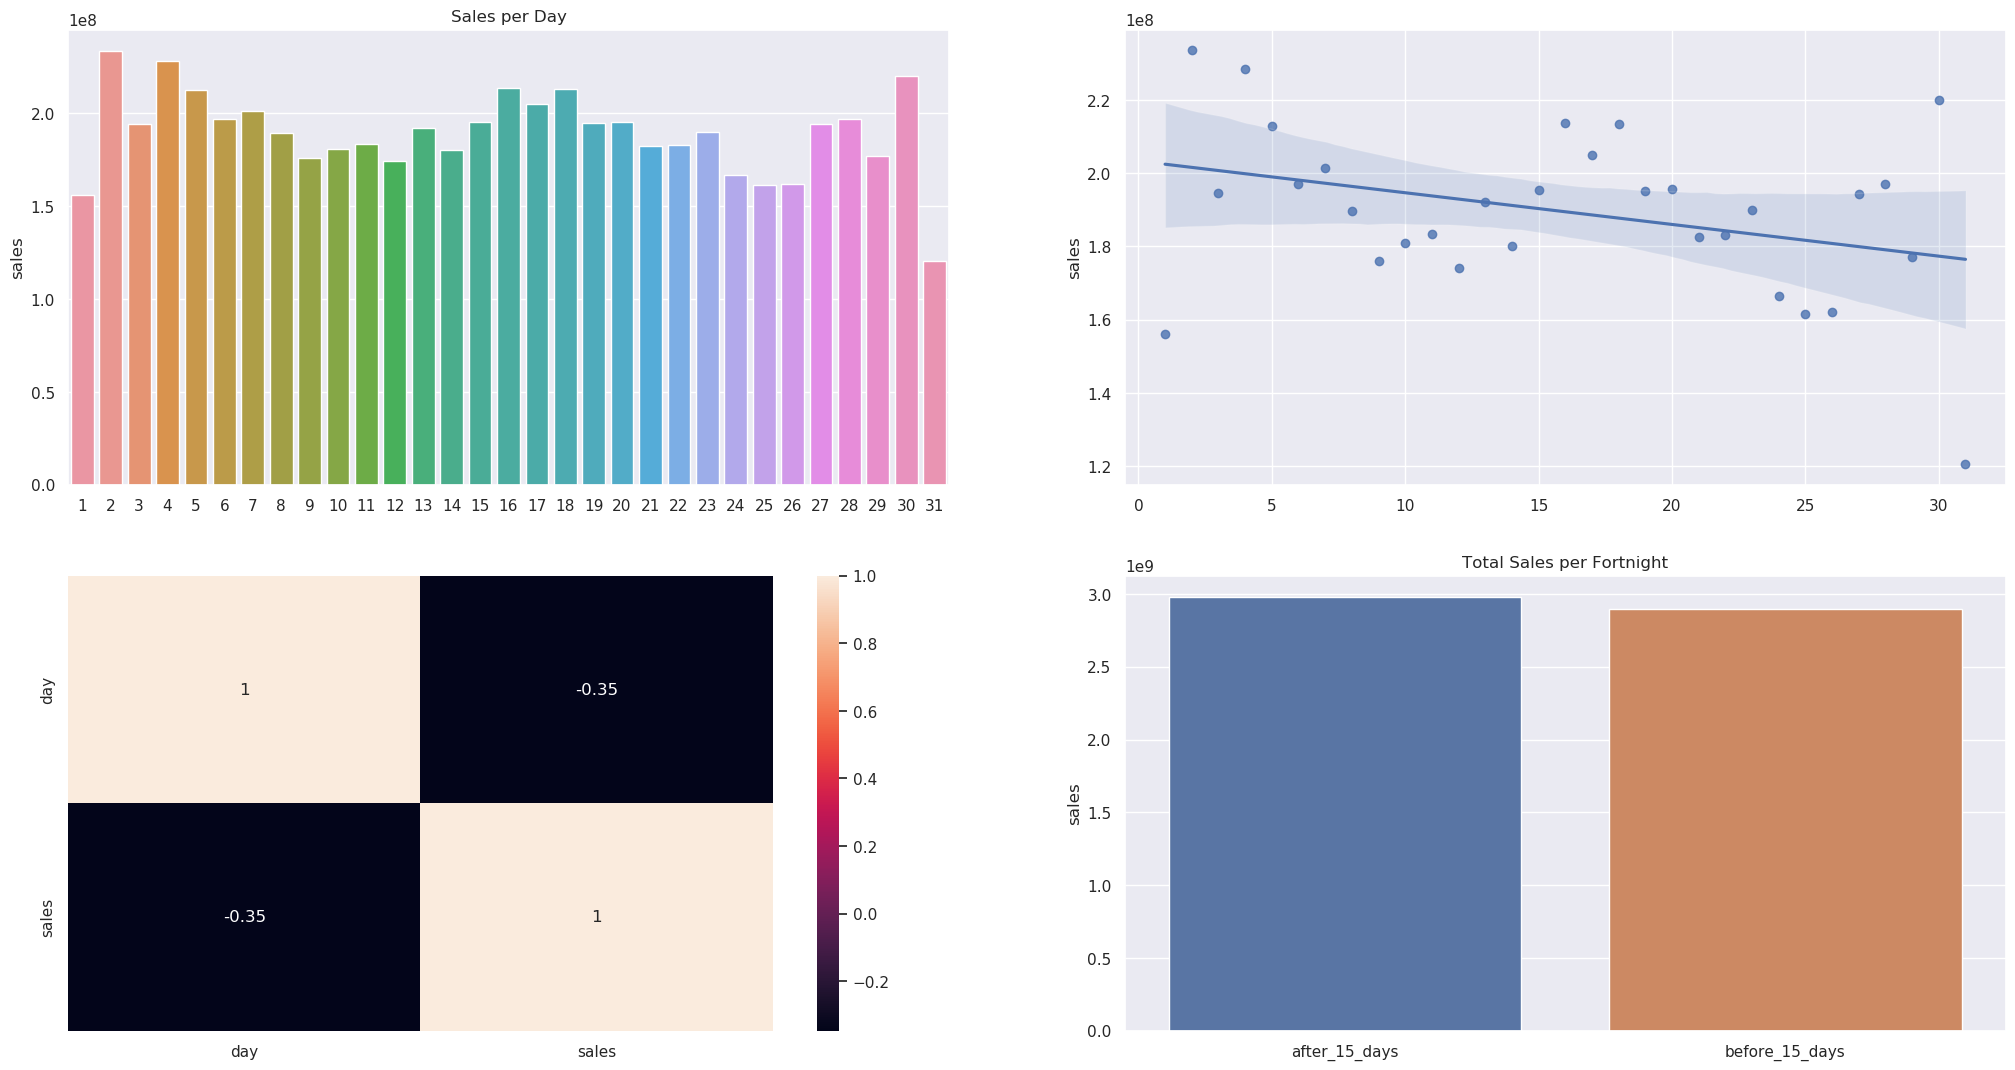

In [84]:
grid = GridSpec(2,2)


plt.subplot(grid[0,0])

aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index();
g1 = sns.barplot(x='day', y='sales', data= aux1);
g1.set(xlabel=None);
plt.title('Sales per Day');

plt.subplot(grid[0,1])

g2 = sns.regplot(x='day', y='sales', data=aux1);
g2.set(xlabel=None);

plt.subplot(grid[1,0])

sns.heatmap(aux1.corr (method='pearson'), annot=True);

plt.subplot(grid[1,1])
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_15_days' if x <= 15 else 'after_15_days');
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index();
g3 = sns.barplot(x='before_after', y='sales', data= aux2);
plt.title('Total Sales per Fortnight');
g3.set(xlabel=None);

### **H8.** Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA** - Lojas VENDEM MENOS aos FDS

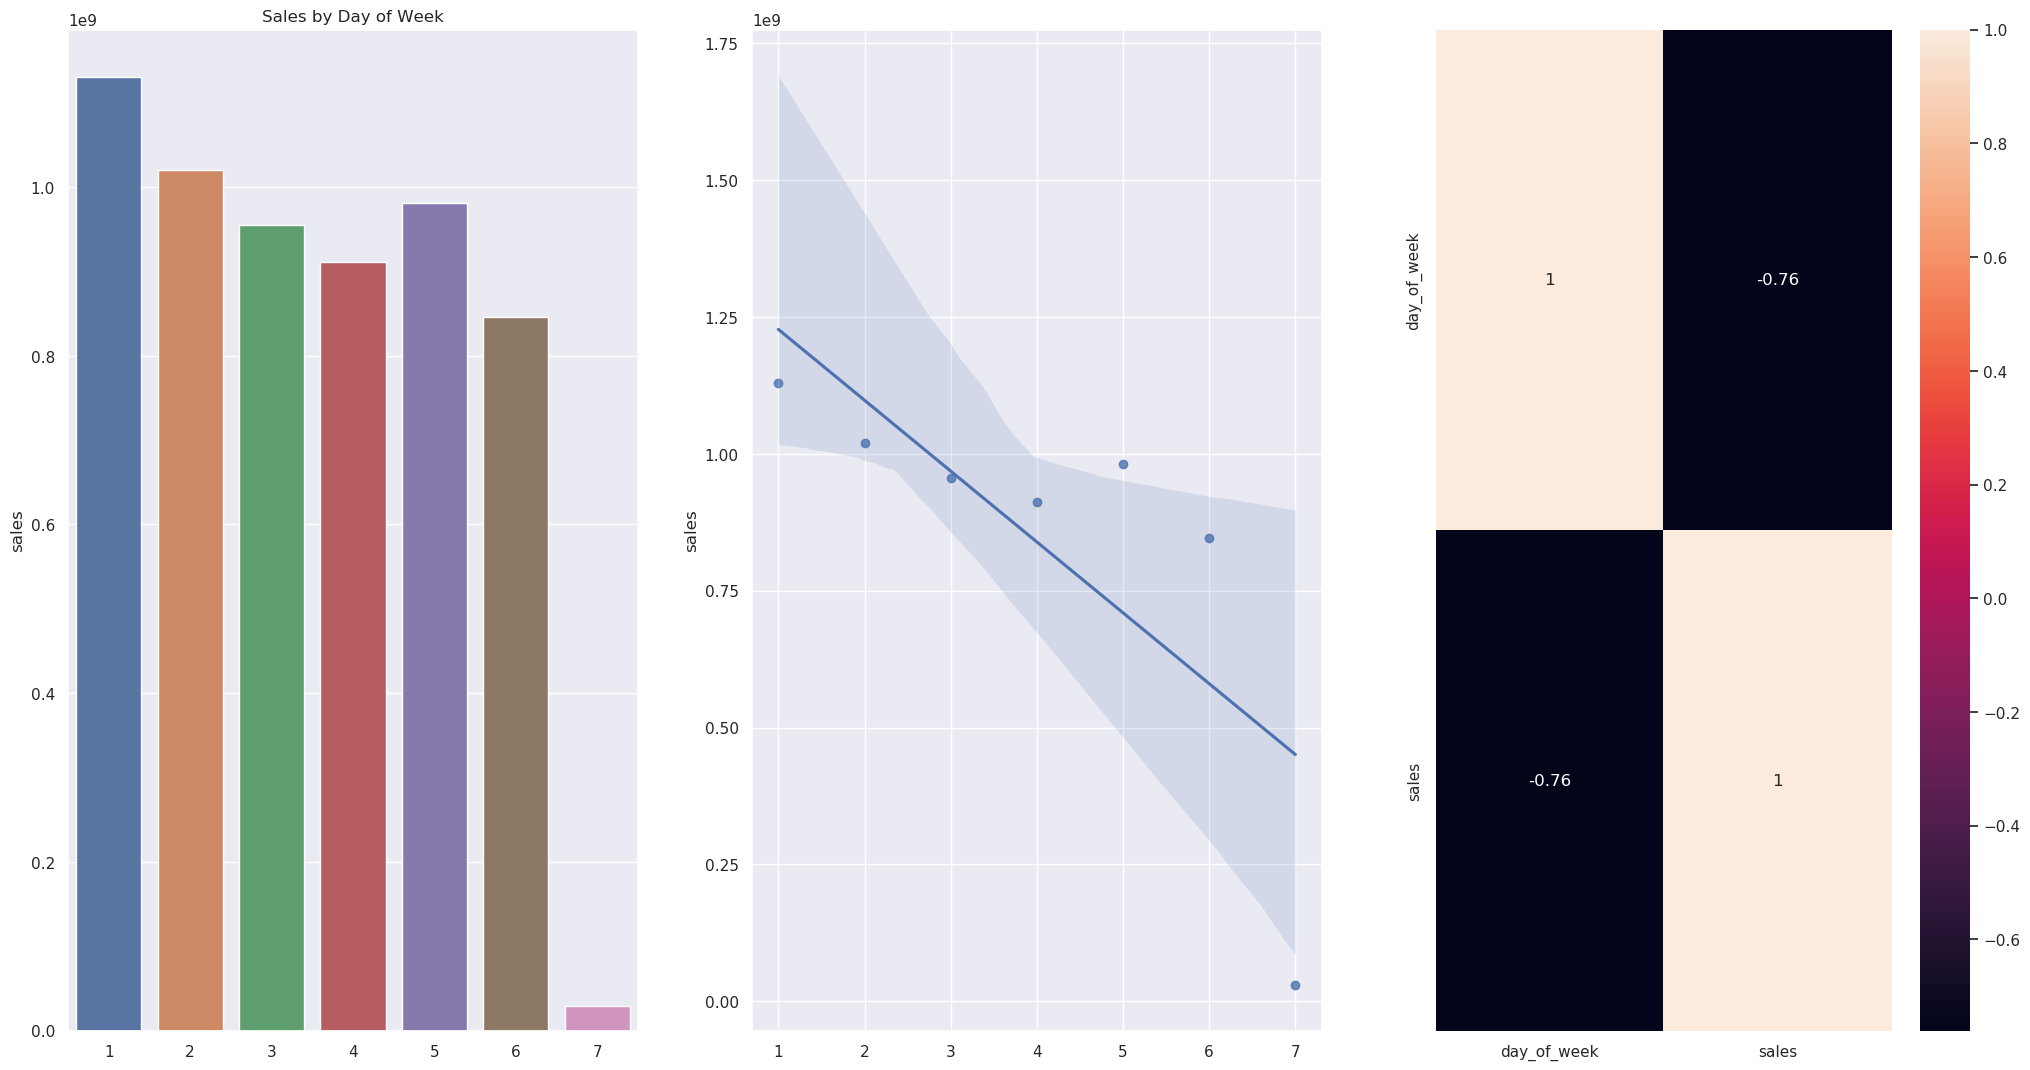

In [85]:
grid = GridSpec(1,3)


plt.subplot(grid[0,0])

aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
g1 = sns.barplot(x='day_of_week', y='sales', data= aux1);
g1.set(xlabel=None)
plt.title('Sales by Day of Week');

plt.subplot(grid[0,1])

g2 = sns.regplot(x='day_of_week', y='sales', data=aux1);
g2.set(xlabel=None)

plt.subplot(grid[0,2])

sns.heatmap(aux1.corr (method='pearson'), annot=True);

### **H9.** Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA** - Lojas VENDEM MENOS durante os FERIADOS ESCOLARES, exceto em agosto.

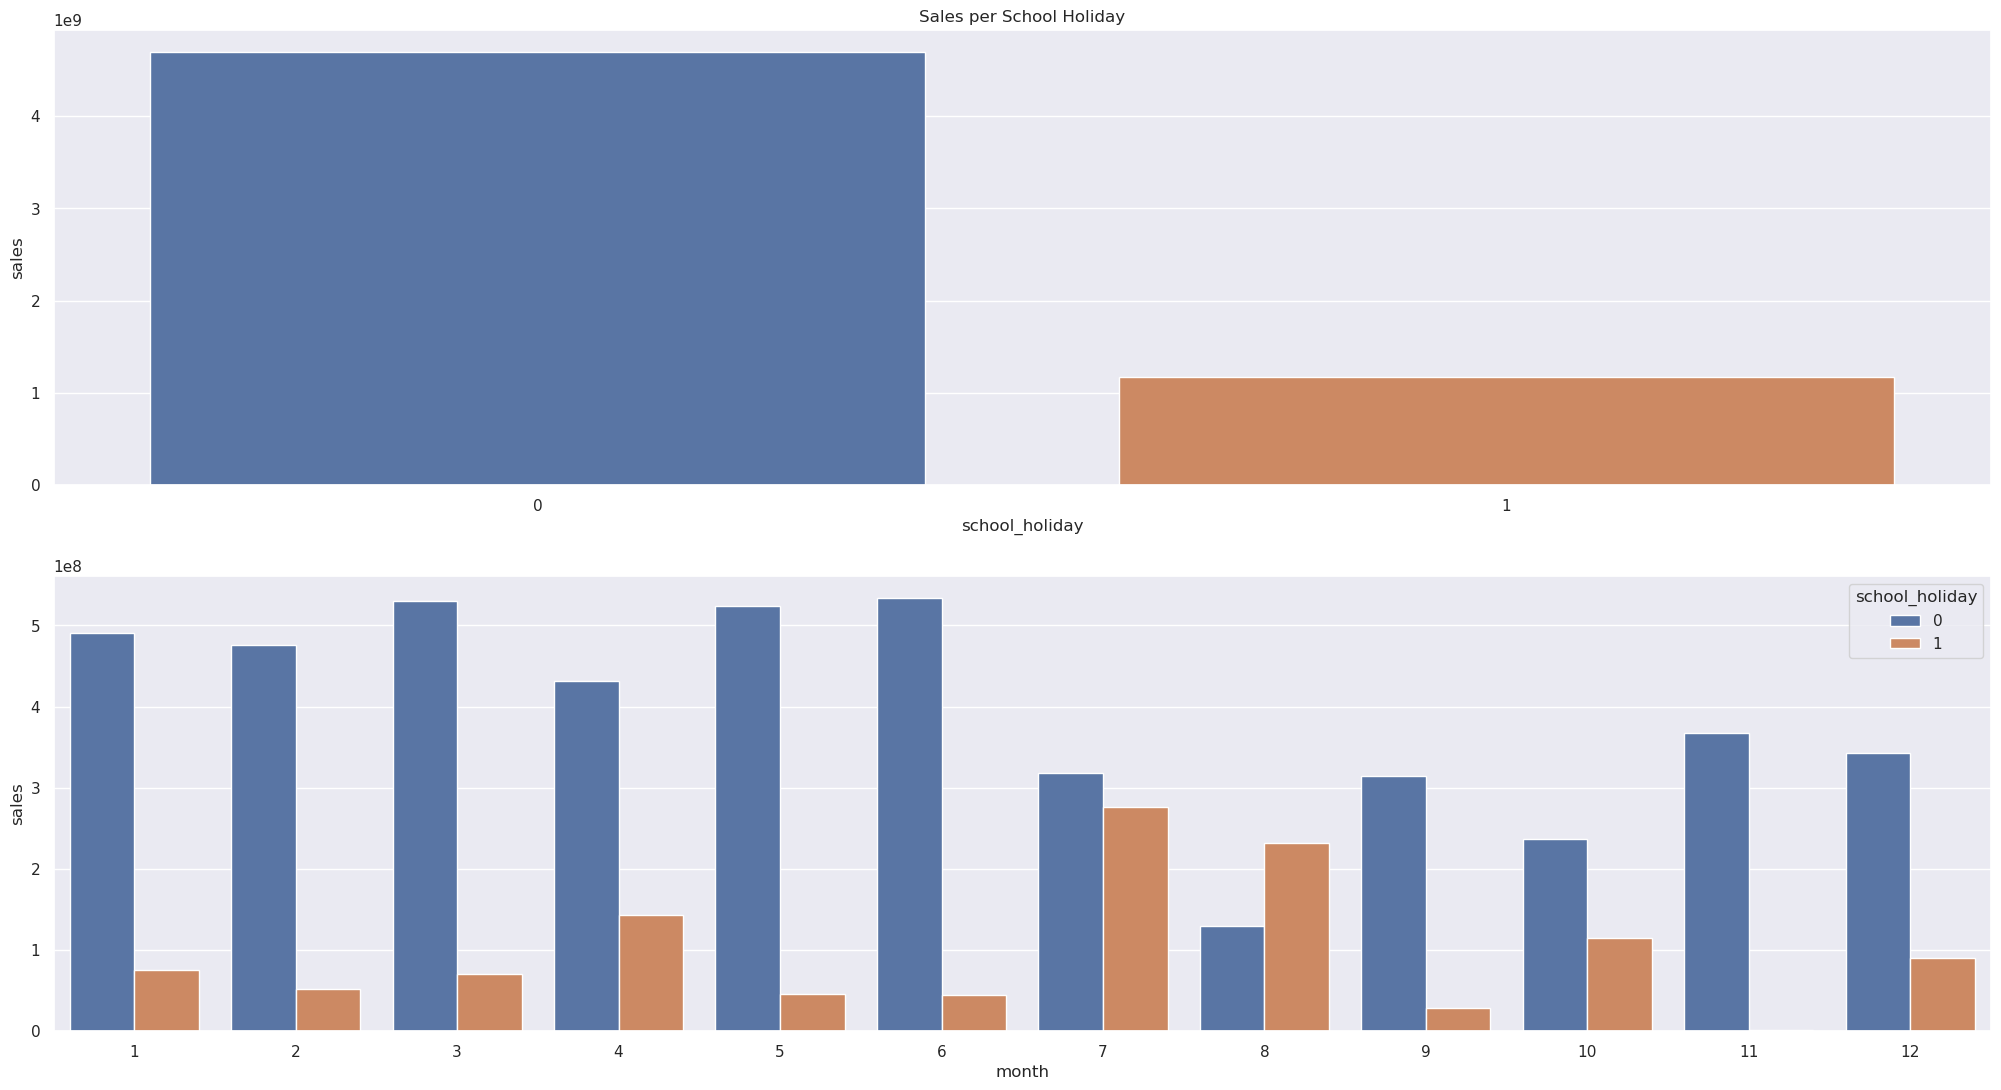

In [86]:
grid = GridSpec(2,1)


plt.subplot(grid[0,0])

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data= aux1);
plt.title('Sales per School Holiday');

plt.subplot(grid[1,0])

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data= aux2);

### 4.2.1. Resumo das Hipoteses

In [87]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
#Lojas com maior sortimento vendem mais
       ['H1', 'Falsa', 'Alta'],
#Lojas com competidores mais próx deveriam vender menos
       ['H2', 'Falsa', 'Media'],
#Lojas com competidores há mais tempo deveriam vender mais
       ['H3', 'Falsa', 'Media'],
#Lojas que participam das duas promoções deveriam vender mais
       ['H4', 'Falsa', 'Alta'],
#Lojas abertas durante o feriado de Natal deveriam vender mais
       ['H5', 'Falsa', 'Media'],
#Lojas deveriam vender mais ao longo dos anos
       ['H6', 'Falsa', 'Media'],
#Lojas deveriam vender mais na primeira quinzena de cada mês.
       ['H7', 'Verdadeira', 'Media'],
#Lojas deveriam vender menos aos finais de semana.
       ['H8', 'Verdadeira', 'Alta'],
#Lojas deveriam vender menos durante os feriados escolares.
       ['H9', 'Verdadeira', 'Baixa']]

print(tabulate (tab, headers= 'firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Alta
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Alta
H5           Falsa        Media
H6           Falsa        Media
H7           Verdadeira   Media
H8           Verdadeira   Alta
H9           Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1 Numerical Attributes

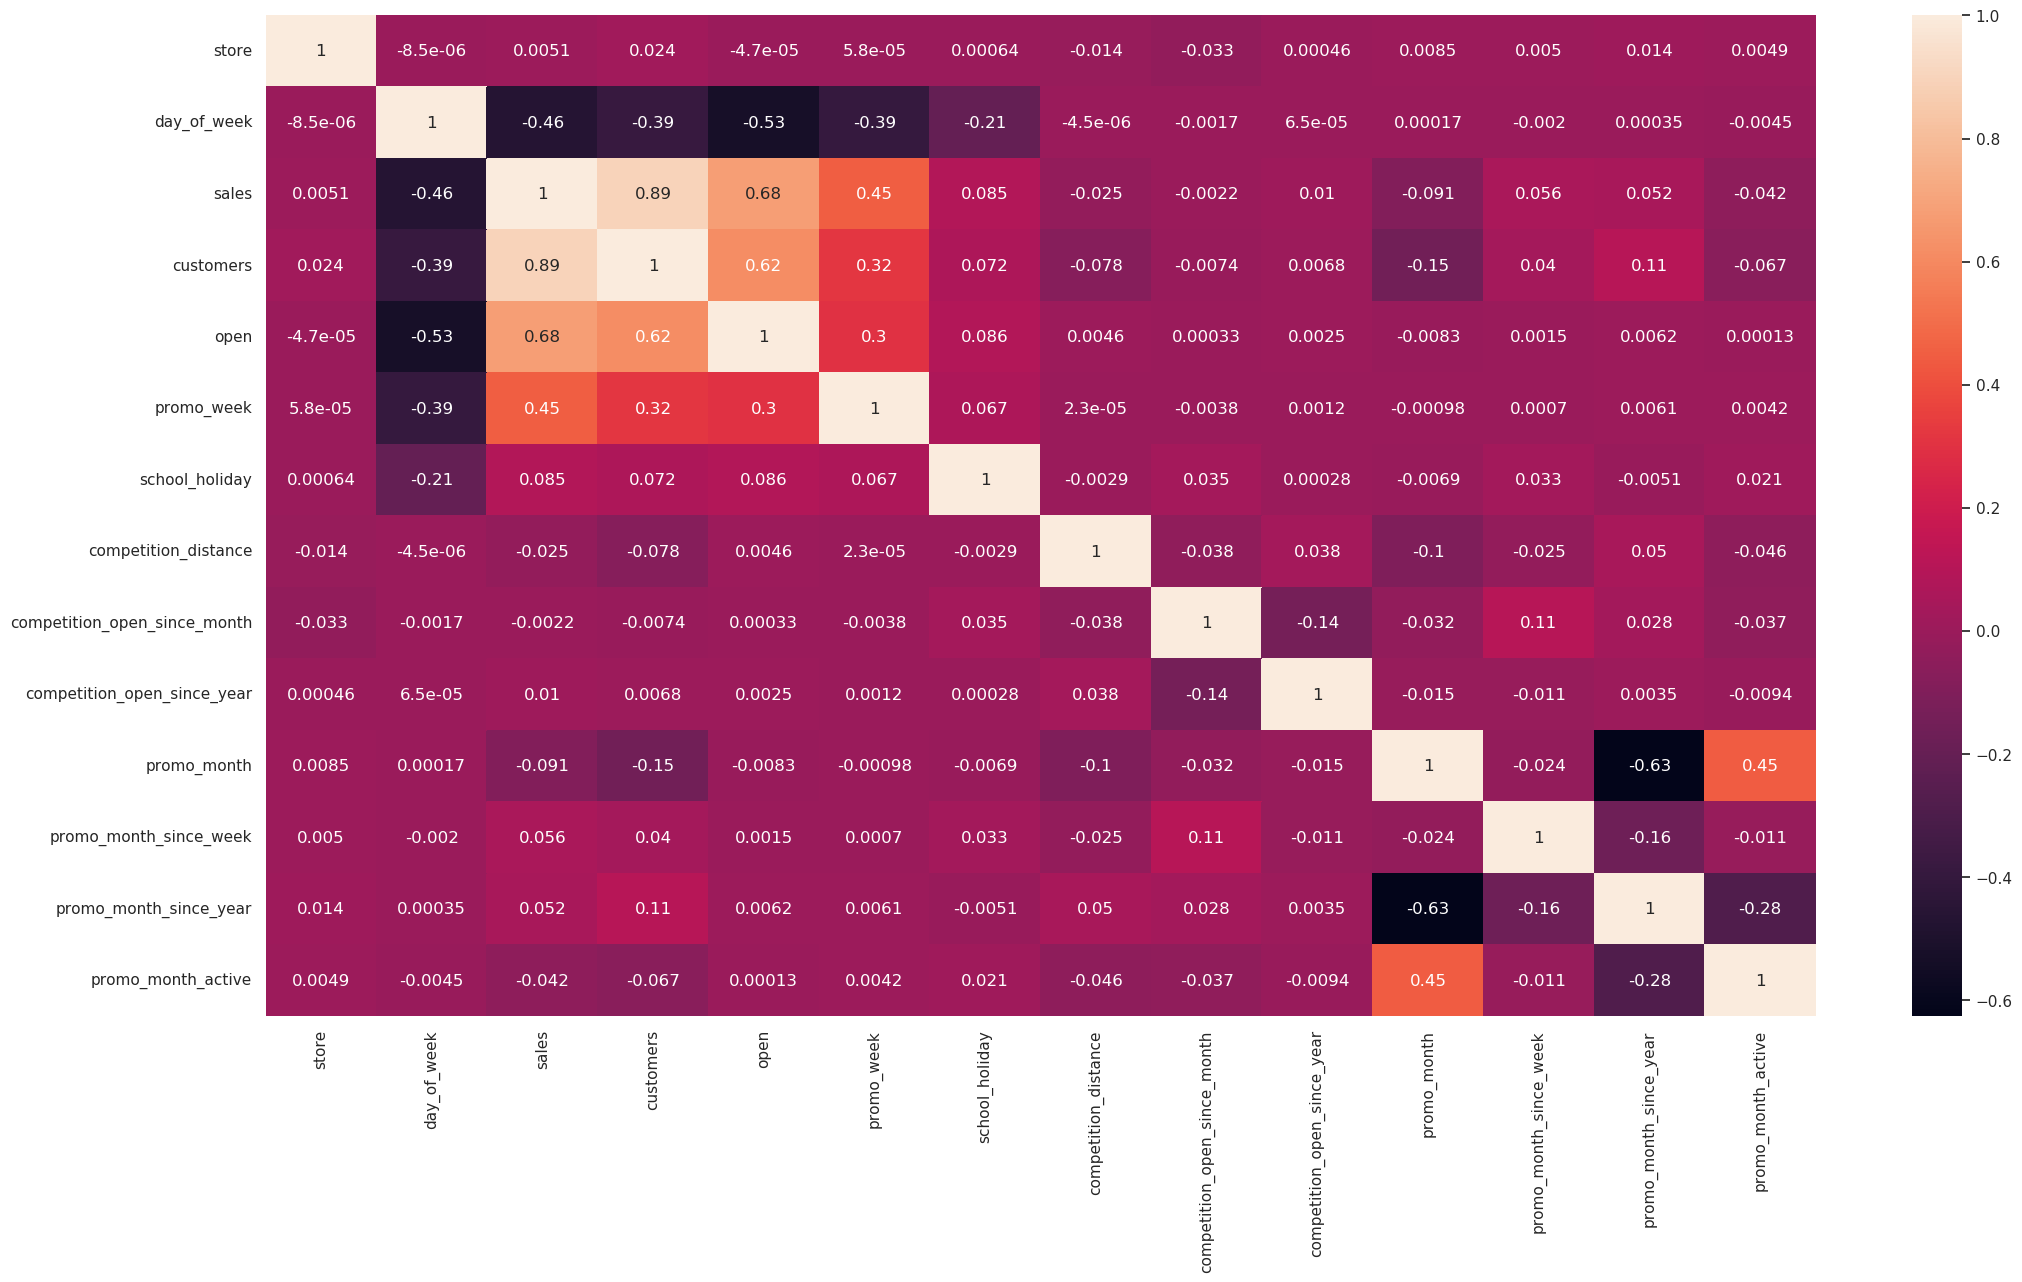

In [88]:
correlation = num_attributes.corr(method= 'pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

In [89]:
# only categorical data
a = df4.select_dtypes(include= 'object')

In [90]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [91]:
#calculate cramer V
a1 = cramer_v(a['state_holiday'] , a['state_holiday'])
a2 = cramer_v(a['state_holiday'] , a['store_type'])
a3 = cramer_v(a['state_holiday'] , a['assortment'])

a4 = cramer_v(a['store_type'] , a['state_holiday'])
a5 = cramer_v(a['store_type'] , a['store_type'])
a6 = cramer_v(a['store_type'] , a['assortment'])

a7 = cramer_v(a['assortment'] , a['state_holiday'])
a8 = cramer_v(a['assortment'] , a['store_type'])
a9 = cramer_v(a['assortment'] , a['assortment'])

d= pd.DataFrame ({'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]})

#final dataset
d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


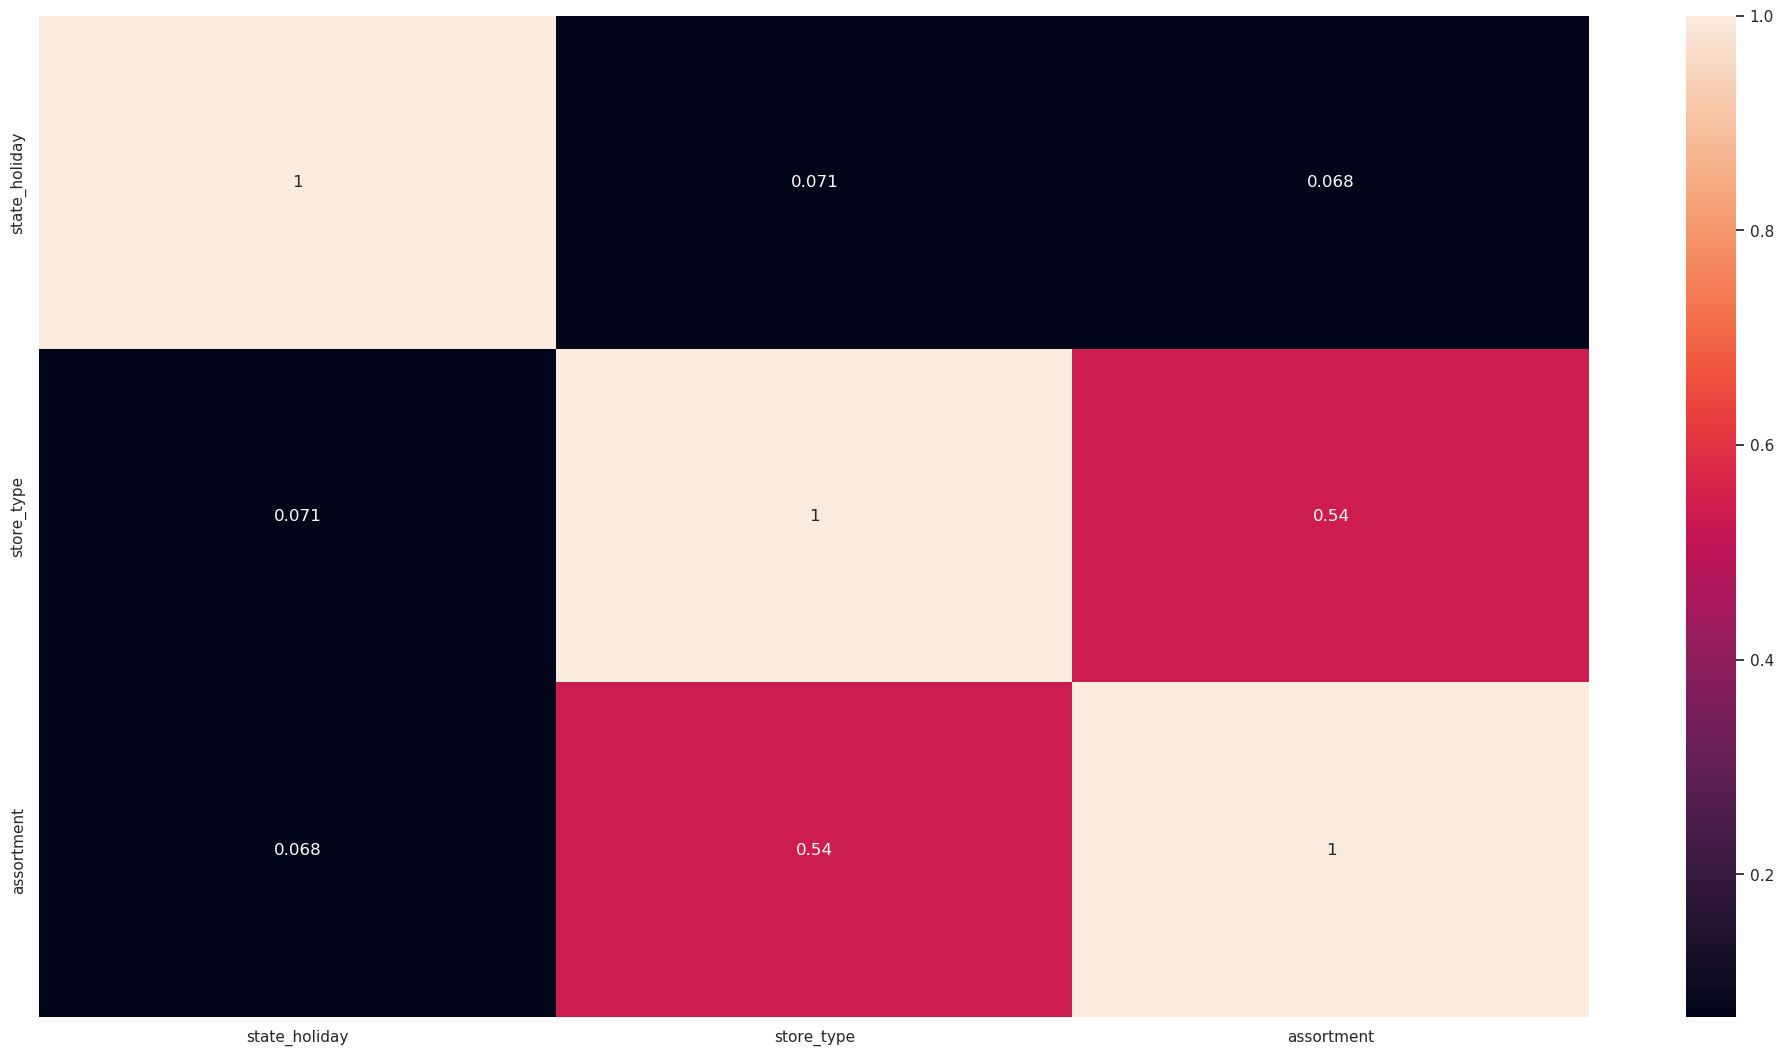

In [92]:
sns.heatmap(d, annot=True);

# 5.0. Data Preparation


In [93]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [94]:
a = df5.select_dtypes(include= ['int64', 'float64'])

In [95]:
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
#pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
#pickle.dump(mms, open('../parameter/year_scaler.pkl', 'wb') )            
            
# promo month time week
df5['promo_month_time_week'] = mms.fit_transform(df5[['promo_month_time_week']].values)
#pickle.dump(mms, open('../parameter/promo_month_time_week_scaler.pkl', 'wb'))


## 5.3. Transformação

### 5.3.1. Enconding

In [96]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type - Label Encoding
df5['store_type'] = le.fit_transform(df5['store_type'])
#pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb') )


# assortment - Ordinal Encoding
assortment_dict = {'basic': 1 , 'extra': 2 , 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2. Response Variable Transformation

In [97]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [98]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin (x * (2. * np.pi / 7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos (x * (2. * np.pi / 7) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin (x * (2. * np.pi / 12) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos (x * (2. * np.pi / 12) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin (x * (2. * np.pi / 30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos (x * (2. * np.pi / 30) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin (x * (2. * np.pi / 52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos (x * (2. * np.pi / 52) ) )

In [99]:
df5.head()

,store,day_of_week,date,sales,promo_week,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo_month,promo_month_since_week,promo_month_since_year,promo_month_active,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_month_since_date,promo_month_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. Feature Selection

In [100]:
df6 = df5.copy()

## 6.1. Split Dataframe into Training and Test Dataset

In [101]:
cols_drop = ['year', 'month', 'day', 'week_of_year', 'promo_month_since_date', 'competition_since', 'year_week']
df6 = df6.drop (cols_drop, axis=1)

In [102]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta (days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [103]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset (validation)
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format(X_train['date'].min()))
print( 'Training Max Date: {}'.format(X_train['date'].max()))


print( '\nTest Min Date: {}'.format(X_test['date'].min()))
print( 'Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [104]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop (['date', 'sales'], axis = 1).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor (n_jobs = -1)

# # define Boruta
# boruta = BorutaPy (rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n)

### 6.2.1. Best Features from Boruta

In [105]:
# cols_selected = boruta.support_.tolist()


# # best_features
# X_train_fs = X_train.drop (['date', 'sales'], axis = 1)
# cols_selected_boruta = X_train.iloc [:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [106]:
# cols_selected_boruta


# ['store',
#  'promo_week',
#  'store_type',
#  'assortment',
#  'competition_distance',
#  'competition_open_since_month',
#  'competition_open_since_year',
#  'promo_month',
#  'promo_month_since_week',
#  'promo_month_since_year',
#  'competition_time_month',
#  'promo_month_time_week',
#  'day_of_week_sin',
#  'day_of_week_cos',
#  'month_cos',
#  'day_sin',
#  'day_cos',
#  'week_of_year_cos']

In [107]:
# cols_not_selected_boruta

# ['promo_month_active',
#  'month_sin',
#  'school_holiday',
#  'state_holiday_christmas',
#  'state_holiday_easter_holiday',
#  'state_holiday_public_holiday',
#  'state_holiday_regular_day',
#  'week_of_year_sin',
#  'year']

## 6.3. Manual Features Selection

In [108]:
cols_selected_boruta = [
    'store',
    'promo_week',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo_month',
    'promo_month_since_week',
    'promo_month_since_year',
    'competition_time_month',
    'promo_month_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add

feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. Machine Learning Modelling

In [109]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [110]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# predictions
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge (aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error ('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [111]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict (x_test)

# performance
lr_result = ml_error ('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [112]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=True)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1980.04 +/- 0.0,0.28 +/- 0.0,2840.0 +/- 0.0


## 7.3. Linear Regression Regulaized Model - Lasso

In [113]:
# model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict (x_test)

# performance
lrr_result = ml_error ('Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1891.704881,0.289106,2744.451737


 ### 7.3.1. Lasso - Cross Validation

In [114]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose= True )
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2014.53 +/- 0.0,0.28 +/- 0.0,2918.82 +/- 0.0


## 7.4. Random Forest Regressor

In [119]:
# model
rfr = RandomForestRegressor(n_estimators= 100, n_jobs= -1, random_state= 42).fit(x_train, y_train)

# prediction
yhat_rfr = rfr.predict (x_test)

# performance
rfr_result = ml_error ('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rfr))
rfr_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


 ### 7.4.1. Random Forest Regressor - Cross Validation

In [120]:
rfr_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rfr, verbose=True)
rfr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,696.66 +/- 0.0,0.1 +/- 0.0,1003.81 +/- 0.0


## 7.5. XGBoost Regressor

In [121]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict (x_test)

# performance
xgb_result = ml_error ('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,890.527565,0.129193,1306.496922


 ### 7.5.1. XGBoost Regressor - Cross Validation

In [122]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,987.94 +/- 0.0,0.13 +/- 0.0,1407.43 +/- 0.0


## 7.6. Compare Model's Performance

###  7.6.1. Single Performance

In [123]:
modelling_result = pd.concat ([ baseline_result, lr_result, lrr_result, rfr_result, xgb_result ])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,XGBoost Regressor,890.527565,0.129193,1306.496922
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Lasso,1891.704881,0.289106,2744.451737


###  7.6.2. Real Performance - Cross Validation

In [124]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rfr_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,696.66 +/- 0.0,0.1 +/- 0.0,1003.81 +/- 0.0
0,XGBoost Regressor,987.94 +/- 0.0,0.13 +/- 0.0,1407.43 +/- 0.0
0,Linear Regression,1980.04 +/- 0.0,0.28 +/- 0.0,2840.0 +/- 0.0
0,Lasso,2014.53 +/- 0.0,0.28 +/- 0.0,2918.82 +/- 0.0


# 8.0. Hyperparameter Fine Tuning


### 8.1. Random Search

In [ ]:
# param = {'n_estimators': [1500, 2000, 3000],
#          'eta': [0.01, 0.03],
#          'max_depth': [6,8,10],
#          'subsample': [0.6, 0.7],
#          'colsample_bytree': [0.7, 0.9],
#          'min_child_weight': [3, 8, 15]
#          }

# MAX_EVAL = 2

In [ ]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#     # chose values for parameters randomly
#     hp = {k: random.sample(v,1)[0] for k, v in param.items() }
#     print( hp )
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'] )

#     # performance
#     result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
#     final_result = pd.concat( [final_result, result])

# final_result

### 8.2. Final Model

In [131]:
param_tuned = {'n_estimators':1500 ,
               'eta': 0.03,
               'max_depth': 9,
               'subsample': 0.7,
               'colsample_bytree': 0.9,
               'min_child_weight': 8
               }


In [132]:
# model
xgb_model_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                   n_estimators = param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree = param_tuned['colsample_bytree'],
                                   min_child_weight = param_tuned['min_child_weight'] ).fit(x_train, y_train);


# prediction
yhat_xgb_tuned = xgb_model_tuned.predict(x_test)

# performance
xgb_tuned_result = ml_error('XGBoost Regressor (Tuned)', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_tuned_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor (Tuned),614.314201,0.089318,898.917048


In [143]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))

print(f"Média de vendas por dia (todas as lojas): {np.expm1(y_test).mean()}")

print(f"\nMAE e MAPE: Com um MAE de 614, a cada predição que o modelo fizer, ele erra em média, ± 9% da previsão total ")

print(f"\nRMSE: Para cada predição, o modelo erra em média, ± 899 por dia")

print(f"\nMPE: As estimativas estão desviando cerca de {round((mpe * 100),3)} % do valor real")

Média de vendas por dia (todas as lojas): 6995.162576094309

MAE e MAPE: Com um MAE de 614, a cada predição que o modelo fizer, ele erra em média, ± 9% da previsão total 

RMSE: Para cada predição, o modelo erra em média, ± 899 por dia

MPE: As estimativas estão desviando cerca de 0.052 % do valor real


In [ ]:
# pickle.dump (xgb_model_tuned, open ('../model/model_rossmann.pkl', 'wb') )
# pickle.dump (yhat_xgb_tuned, open ('../model/yhat_xgb_tuned.pkl', 'wb') )

# 9.0.Translation and Interpretation of the Error

In [134]:
df9 = X_test [cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [135]:
# soma das previsoes
df9_sum = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE de cada loja
df9_error1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df9_error2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE (%)'})

# merge
df9_errors = pd.merge (df9_error1, df9_error2, how='inner', on='store')
df9_comp = pd.merge(df9_sum, df9_errors, how='inner', on='store')

# cenarios
df9_comp['worst_scenario'] = df9_comp['predictions'] - df9_comp['MAE']
df9_comp['best_scenario'] = df9_comp['predictions'] + df9_comp['MAE']

# ordem colunas
df9_comp = df9_comp[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE (%)']]

### Previsão de Receita para as próximas 6 semanas:

In [136]:
df9_comp.sort_values('MAPE (%)', ascending = True).head(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE (%)
258,259,543817.625000,543254.721930,544380.528070,562.903070,0.045248
732,733,635609.500000,634954.387377,636264.612623,655.112623,0.045365
1096,1097,455389.312500,454891.568496,455887.056504,497.744004,0.046396
582,583,154103.062500,153899.239449,154306.885551,203.823051,0.047429
567,568,195403.328125,195125.456978,195681.199272,277.871147,0.052551


In [137]:
df9_comp.sort_values('MAPE (%)', ascending = False).head(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE (%)
291,292,106682.843750,103408.477809,109957.209691,3274.365941,0.550376
908,909,245000.531250,237411.067616,252589.994884,7589.463634,0.534683
875,876,208180.781250,204286.841171,212074.721329,3893.940079,0.296450
721,722,343961.250000,342213.540633,345708.959367,1747.709367,0.237390
182,183,198045.046875,196687.532431,199402.561319,1357.514444,0.220765


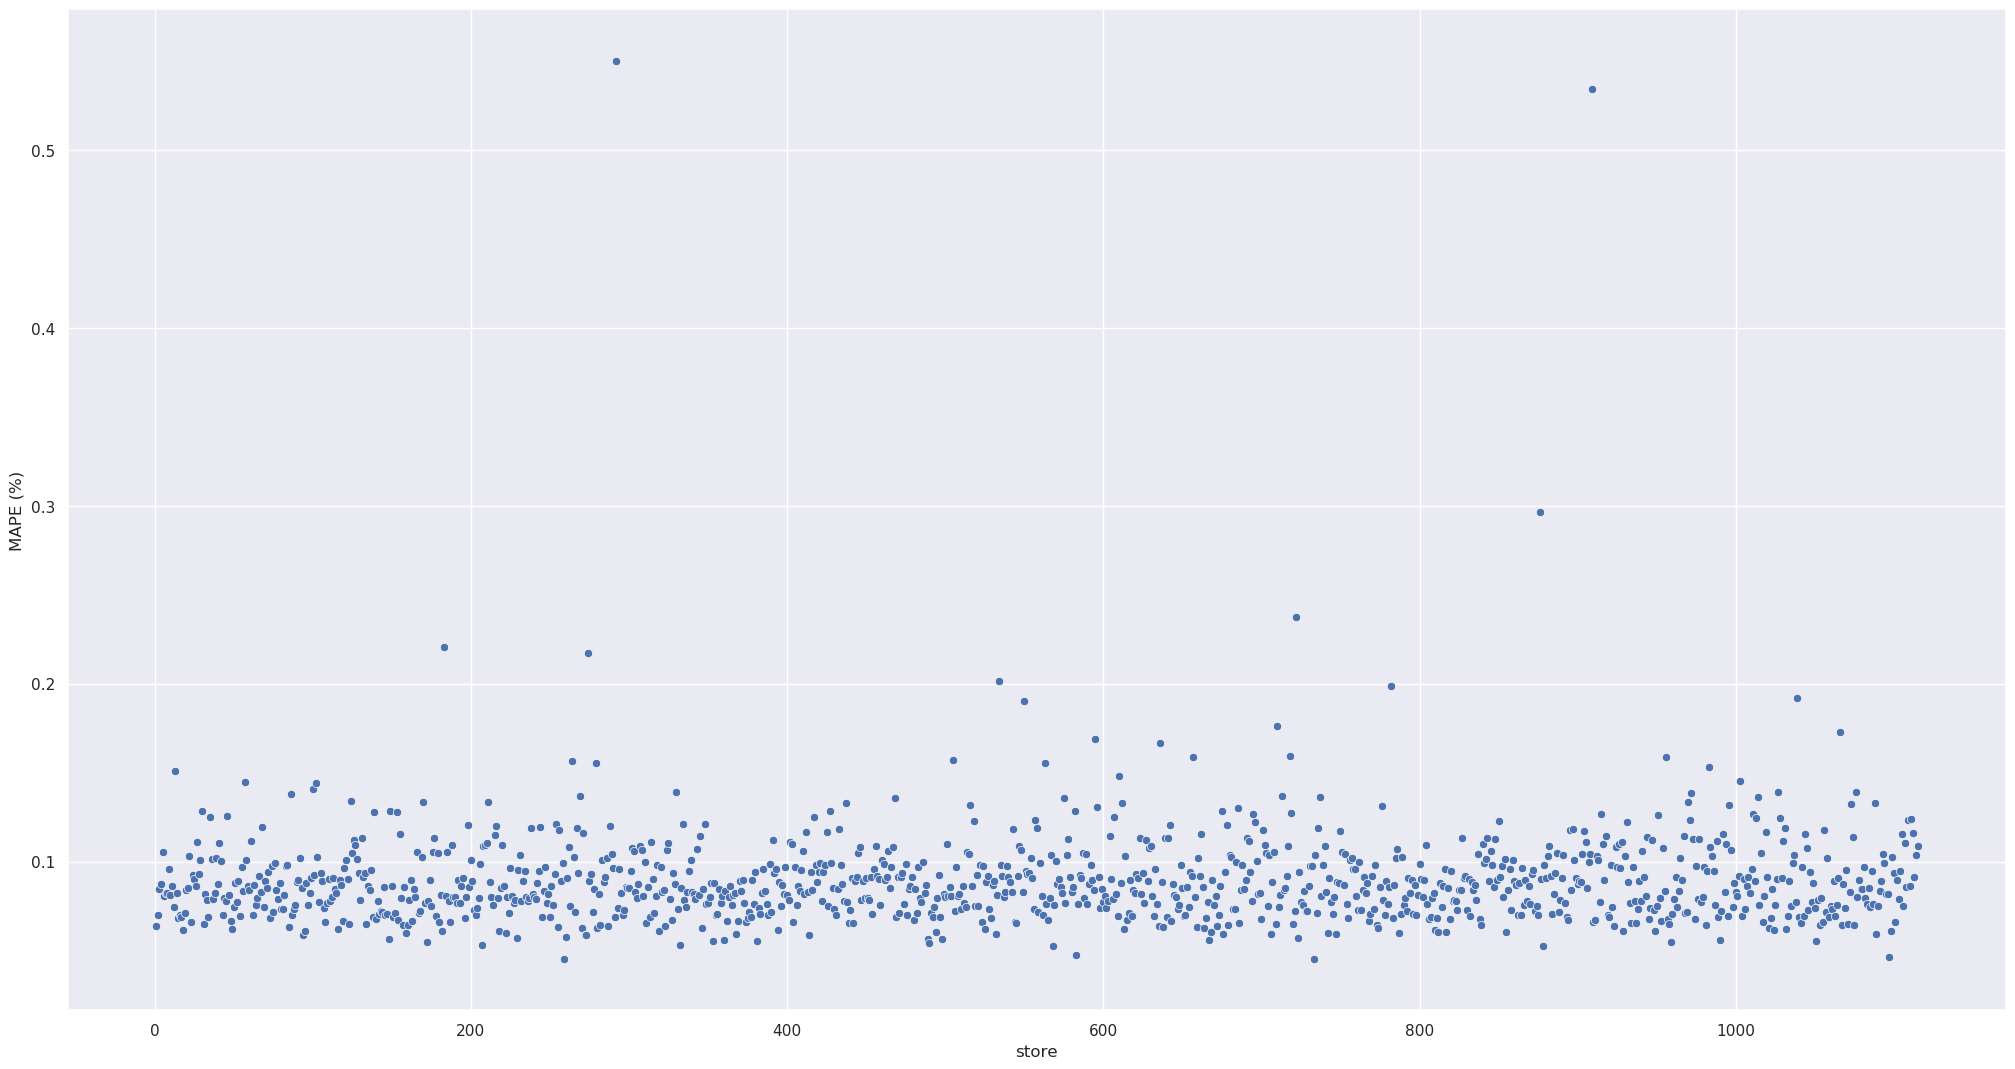

In [138]:
sns.scatterplot (x='store', y='MAPE (%)', data=df9_comp);

## 9.2. Total Performance

In [139]:
df9_perf = df9_comp[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns= {'index': 'Scenario' , 0: 'Revenues (6w)'})
df9_perf['Revenues (6w)'] = df9_perf['Revenues (6w)'].map ('{:,.2f}'.format)
df9_perf


,Scenario,Revenues (6w)
0,predictions,"285,743,680.00"
1,worst_scenario,"285,054,422.60"
2,best_scenario,"286,432,960.15"


### 9.3. Machine Learning Performance

In [140]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/ df9['sales']

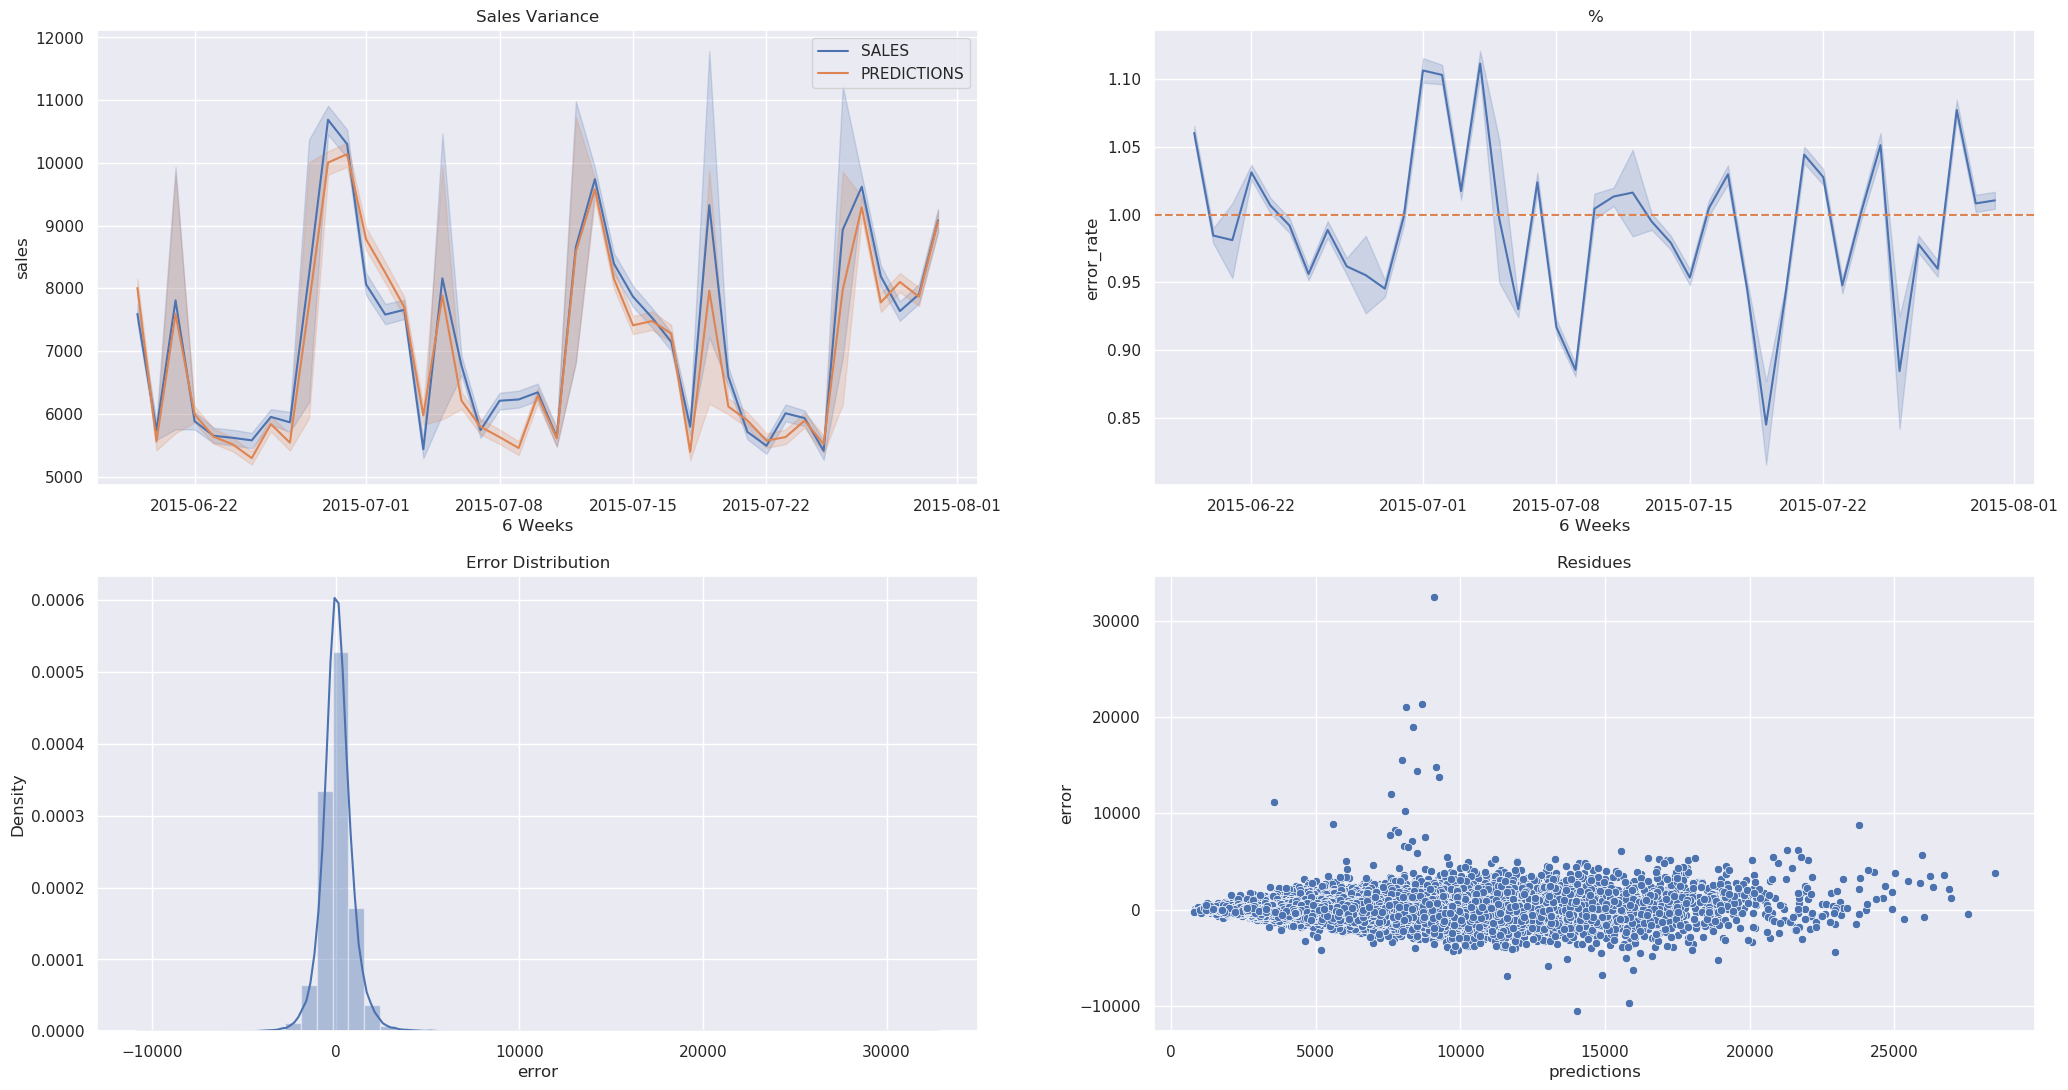

In [141]:
plt.subplot (2,2,1)
sns.lineplot (x='date', y='sales', data=df9, label='SALES');
sns.lineplot (x='date', y='predictions', data=df9, label= 'PREDICTIONS');
plt.title('Sales Variance');
plt.xlabel('6 Weeks');

plt.subplot (2,2,2)
sns.lineplot (x='date', y='error_rate', data=df9);
plt.axhline (1, linestyle = '--', color='C1')
plt.title('%');
plt.xlabel('6 Weeks');

plt.subplot (2,2,3)
sns.distplot (df9['error']);
plt.title('Error Distribution');

plt.subplot (2,2,4)
sns.scatterplot (x = 'predictions', y = 'error', data = df9);
plt.title('Residues');


# 10.0. Deploy Model to Production

## 10.1. Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/caroline/repos/ds_em_producao/
        self.competition_distance_scaler = pickle.load (open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'));
        self.competition_time_month_scaler = pickle.load (open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_month_time_week_scaler = pickle.load (open(self.home_path + 'parameter/promo_month_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load (open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load (open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self,df1):
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
                    'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore (x)
        cols_new = list (map (snakecase, cols_old) )
        
        df1.columns = cols_new
        df1 = df1.rename(columns={'promo' :'promo_week', 
                                  'promo2' : 'promo_month', 
                                  'promo2_since_week' : 'promo_month_since_week', 
                                  'promo2_since_year' : 'promo_month_since_year'})
        
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        
        ## 1.5. Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply (lambda x : 200000.0 if math.isnan ( x ) else x)
        
        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan (x ['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
        
        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan (x ['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

        # promo_month_since_week
        df1['promo_month_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan (x ['promo_month_since_week']) else x['promo_month_since_week'], axis = 1)


        # promo_month_since_year
        df1['promo_month_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan (x ['promo_month_since_year']) else x['promo_month_since_year'], axis = 1)
        
        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna (0, inplace = True)
        df1['month_map'] = df1['date'].dt.month.map (month_map)
        df1['promo_month_active'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )

        ## 1.6. Change Types

        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype (int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype (int)

        #promo_month_since
        df1['promo_month_since_week'] = df1['promo_month_since_week'].astype (int)
        df1['promo_month_since_year'] = df1['promo_month_since_year'].astype (int)

        return df1
        
        
    def feature_engineering(self,df2):
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime ('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day= 1), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

        # promo_month
        df2['promo_month_since_date'] = df2['promo_month_since_year'].astype(str) + '-' + df2['promo_month_since_week'].astype(str)
        
        df2['promo_month_since_date'] = df2['promo_month_since_date'].apply(lambda x: datetime.datetime.strptime (x + '-1', '%Y-%W-%w') - datetime.timedelta (days = 7))
        
        df2['promo_month_time_week'] = ((df2['date'] - df2['promo_month_since_date']) / 7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply (lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply (lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. Variable Filters
        ## 3.1. Filtragem das Linhas

        df2 = df2[df2['open'] != 0]

        ## 3.2. Seleção das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)

        return df2
        
    def data_preparation(self,df5):
        
        ## 5.2. Rescaling
        # competition distance
        
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)
         
        # competition time month
         
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)
         
        # year
         
        df5['year'] = self.year_scaler.transform(df5[['year']].values)
         
        # promo month time week
         
        df5['promo_month_time_week'] = self.promo_month_time_week_scaler.transform(df5[['promo_month_time_week']].values)
         
        ## 5.3. Transformacao
         
        ### 5.3.1. Enconding
         
        # state holiday - One Hot Encoding
         
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
         
        # store type - Label Encoding
         
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])
         
        # assortment - Ordinal Encoding
         
        assortment_dict = {'basic': 1 , 'extra': 2 , 'extended': 3}
         
        df5['assortment'] = df5['assortment'].map(assortment_dict)
         
        ### 5.3.3. Nature Transformation
         
        # day of week
        
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin (x * (2. * np.pi / 7)))
        
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos (x * (2. * np.pi / 7)))
         
        # month
         
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin (x * (2. * np.pi / 12)))
         
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos (x * (2. * np.pi / 12)))
         
        # day
         
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin (x * (2. * np.pi / 30) ) )
         
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos (x * (2. * np.pi / 30) ) )
         
        # week of year
         
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin (x * (2. * np.pi / 52) ) )
         
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos (x * (2. * np.pi / 52) ) )
         
        cols_selected = ['store','promo_week', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_month','competition_open_since_year', 'promo_month',
                         'promo_month_since_year','competition_time_month','promo_month_time_week',
                         'promo_month_since_week','day_of_week_sin', 'day_of_week_cos','month_sin',
                         'month_cos', 'day_sin', 'day_cos','week_of_year_sin', 'week_of_year_cos']
        
        return df5 [cols_selected]
                         
                         
    def get_prediction (self, model, original_data, test_data):
        # prediction
        pred = model.predict (test_data)
        
        # join pred into the original data
        
        original_data['prediction'] = np.expm1 (pred)
        return original_data.to_json (orient = 'records', date_format = 'iso')
    

## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('/home/caroline/repos/ds_em_producao/model/model_rossmann.pkl','rb'))

#initialize API
app = Flask(__name__)
@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json,dict):
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        pipeline = Rossmann()
        
        df1 = pipeline.data_cleaning(test_raw)
        
        df2 = pipeline.feature_engineering(df1)
        
        df3 = pipeline.data_preparation(df2)
        
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        
        return Response('{}', status=200, minetype'application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0')
    

## 10.3. API Tester

In [ ]:
# loading test dataset

df10 = pd.read_csv('../data/test.csv')

# merge test dataset + store 

df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )


# choose store for prediction

df_test = df_test[df_test['Store'].isin( [22, 80, 120] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()] 
df_test = df_test.drop( 'Id', axis=1 )

# convert to DataFrame to json
data = json.dumps( df_test.to_dict( orient='records' ) ) 

In [ ]:
# API Call 
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-api-rvrx.onrender.com/rossmann/predict'

header = {'Content-type': 'application/json'}
data = data
    
r = requests.post (url, data = data, headers = header)
print ('Status Code {}'.format (r.status_code))

In [ ]:
# Convert DataFrame
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )